In [31]:
import pennylane as qml
from pennylane import numpy as np
import torch
from torch.optim import Adam, AdamW, RAdam
from torch.nn.parameter import Parameter
from torch.nn import NLLLoss, BCEWithLogitsLoss
from torch.utils.data import Subset
from torch.utils.data import DataLoader
import torchvision
from torch.nn import Module
import torch.nn.functional as F
from torch.nn import Conv2d, Dropout2d, Linear, Dropout
from torch import cat
from tqdm import tqdm
from torch.optim.lr_scheduler import CosineAnnealingLR
import matplotlib.pyplot as plt
from datetime import datetime
import pprint

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5,), (0.5,)),
        #torchvision.transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        ])


train_ds = torchvision.datasets.FashionMNIST(
    "./", train=True, download=True,
    transform=transform)

test_ds = torchvision.datasets.FashionMNIST(
    "./", train=False, download=True,
    transform=transform)


train_mask = (train_ds.targets == 0) | (train_ds.targets == 6)
train_idx = torch.where(train_mask)[0]
train_ds.targets[train_ds.targets == 6] = 1

batch_size = 50

binary_train_ds = Subset(train_ds, train_idx)
train_loader = DataLoader(binary_train_ds, batch_size = batch_size, shuffle =True)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

In [40]:
torch.set_default_dtype(torch.float64)
class BinaryClassifier(Module):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv2d(1, 8, kernel_size=5, padding=2)
        self.conv2 = Conv2d(8, 25, kernel_size=5, padding=2)
        self.dropout = Dropout2d()
        self.fc1 = Linear(25 * 7 * 7, 36)
        self.fn_dropout = Dropout(p=0.1)
        self.fc2 = Linear(36, 3)
        self.fc3 = Linear(3, 1)

        # Quantum layer
        self.num_q_wires = 3
        self.q_device = qml.device("default.qubit", wires=self.num_q_wires)
        
        self.num_q_layers = 2
        qnn_params_size = (self.num_q_layers * 3 + 2) * self.num_q_wires
        qnn_params_tensor = torch.empty(qnn_params_size, requires_grad=True)

        # Kaiming 초기화의 gain 값 계산 (SiLU에 적합한 'leaky_relu'를 사용)
        gain = torch.nn.init.calculate_gain('leaky_relu')
        std = gain / qnn_params_size**0.5 # 텐서 크기를 이용한 표준 편차 계산
        
        # 균등 분포로 파라미터 초기화
        torch.nn.init.uniform_(qnn_params_tensor, -std, std)

        self.qnn_params = Parameter(qnn_params_tensor)

        #@qml.qnode(self.q_device)
        @qml.qnode(self.q_device, interface="torch")
        def circuit(x_batch):
            param_idx = 0 
            for layer in range(self.num_q_layers): # num_q_layers 만큼 반복
                for i in range(self.num_q_wires):
                    qml.H(wires=i)
                    qml.RZ(2. * x_batch[:, i], wires=i)
                    
                for i in range(self.num_q_wires):
                    qml.CRZ(2. * (torch.pi - x_batch[:, i]) * (torch.pi - x_batch[:, (i+1) % self.num_q_wires]), wires=[i, (i+1)%self.num_q_wires])

                # EfficientSU2
                for i in range(self.num_q_wires):
                    qml.RY(self.qnn_params[param_idx], wires=i)
                    param_idx += 1
                    qml.RX(self.qnn_params[param_idx], wires=i)
                    param_idx += 1
                    #qml.Rot(self.qnn_params[param_idx], self.qnn_params[param_idx+1], torch.tensor(-torch.pi/2, dtype=torch.float64), wires=i)
                    #param_idx += 2
                    qml.Y(wires=i)

                for i in range(self.num_q_wires):
                    qml.CRX(self.qnn_params[param_idx], wires=[i, (i+1)%self.num_q_wires])
                    param_idx += 1
                    #qml.CNOT(wires=[i, (i+1)%self.num_q_wires])

                #for i in range(self.num_q_wires):
                #    qml.Z(wires=i)
                
                if layer == self.num_q_layers-1:
                    for i in range(self.num_q_wires):
                        qml.RY(self.qnn_params[param_idx], wires=i)
                        param_idx += 1
                        qml.RX(self.qnn_params[param_idx], wires=i)
                        param_idx += 1
                        #qml.Rot(self.qnn_params[param_idx], self.qnn_params[param_idx+1], torch.tensor(-torch.pi/2, dtype=torch.float64), wires=i)
                        #param_idx += 2
                        qml.Y(wires=i)
            
            #return qml.expval(self.obs) # qml.expval은 이제 (BATCH_SIZE,) 형태를 반환
            return [qml.expval(qml.PauliZ(i)) for i in range(self.num_q_wires)]

        self.qnn = circuit

    def forward(self, x):
        #x = F.silu(self.conv1(x))
        x = F.leaky_relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        
        #x = F.silu(self.conv2(x))
        x = F.leaky_relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        
        x = self.dropout(x)
        
        x = x.view(x.size(0), -1)
        
        #x = F.silu(self.fc1(x))
        x = F.leaky_relu(self.fc1(x))
        #x = F.dropout(x, p=0.1)
        x = self.fn_dropout(x)

        x = self.fc2(x)
        
        #x = self.qnn(x).view(1,)  # apply QNN
        qnn_out = self.qnn(x) 
        x = torch.stack(qnn_out, dim=-1).to(x.device)
        
        x = self.fc3(x)
        return F.log_softmax(cat((x, 1 - x), -1), -1)

bc = BinaryClassifier()
bc.to(device)

BinaryClassifier(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(8, 25, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (dropout): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=1225, out_features=36, bias=True)
  (fn_dropout): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=36, out_features=3, bias=True)
  (fc3): Linear(in_features=3, out_features=1, bias=True)
)

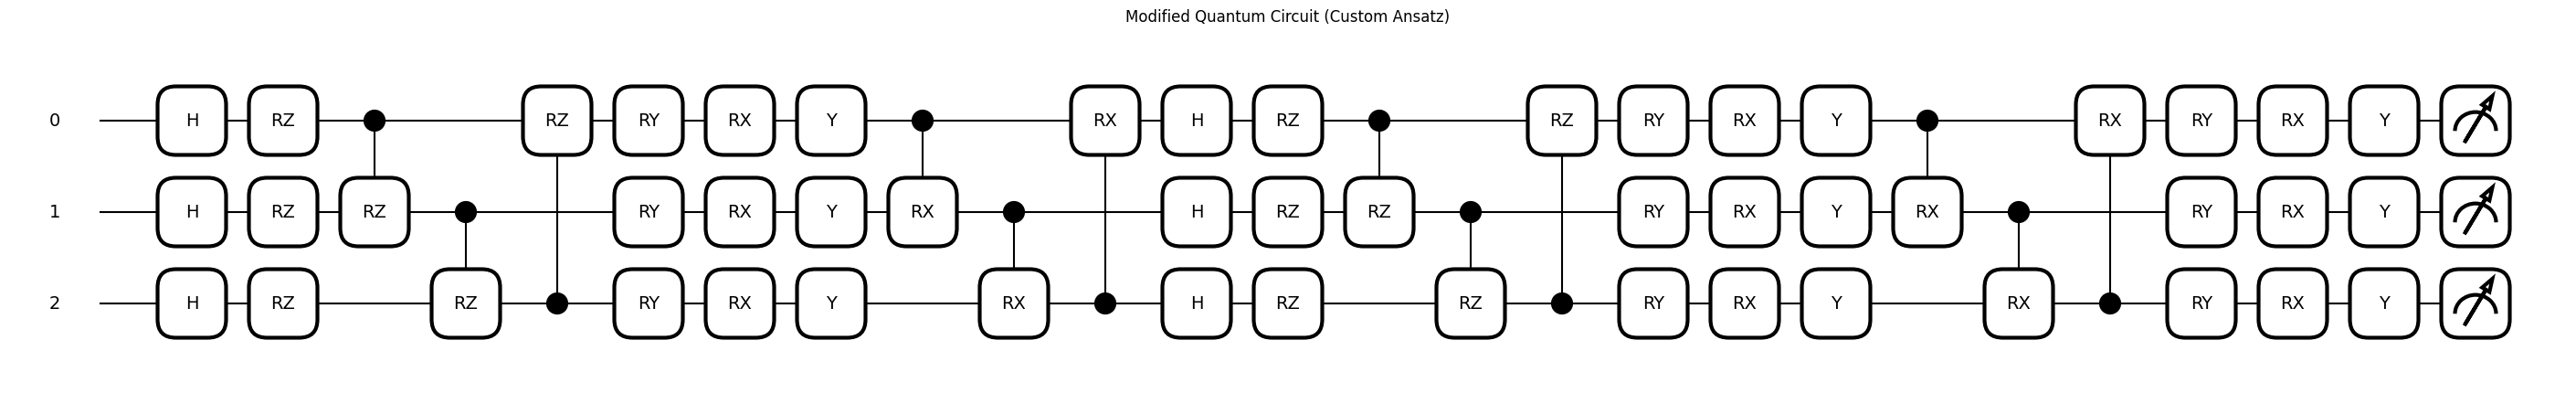

In [41]:
dummy_x = torch.tensor([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], dtype=torch.float64).to(device)
specs = qml.specs(bc.qnn)(dummy_x)
total_params = sum(p.numel() for p in bc.parameters() if p.requires_grad)

# 양자 회로 그리기
fig, ax = qml.draw_mpl(bc.qnn)(dummy_x)
plt.title("Modified Quantum Circuit (Custom Ansatz)")
plt.show()

In [42]:
pprint.pprint(specs, width=1)
print(total_params)
assert specs["num_tape_wires"] <= 8,  "❌ 큐빗 수 초과"
assert specs['resources'].depth <= 30, "❌ 회로 깊이 초과"
assert specs["num_trainable_params"]<= 60, "❌ 학습 퀀텀 파라미터 수 초과"
assert total_params <= 50000, "❌ 학습 전체 파라미터 수 초과"

print("✅ 회로 제약 통과 — 학습을 계속합니다")

{'device_name': 'default.qubit',
 'diff_method': 'best',
 'errors': {},
 'gradient_fn': 'backprop',
 'gradient_options': {},
 'interface': 'torch',
 'level': 'gradient',
 'num_device_wires': 3,
 'num_observables': 3,
 'num_tape_wires': 3,
 'num_trainable_params': 24,
 'resources': Resources(num_wires=3,
                        num_gates=51,
                        gate_types=defaultdict(<class 'int'>,
                                               {'CRX': 6,
                                                'CRZ': 6,
                                                'Hadamard': 6,
                                                'PauliY': 9,
                                                'RX': 9,
                                                'RY': 9,
                                                'RZ': 6}),
                        gate_sizes=defaultdict(<class 'int'>,
                                               {1: 39,
                                                2: 12}),
        

In [43]:
def train_step(epochs=10, lr=0.0010, weight_decay=1e-6):
    optimizer = AdamW(bc.parameters(), lr=lr, weight_decay=weight_decay)
    #optimizer = RAdam(bc.parameters(), lr=lr, weight_decay=weight_decay)
    loss_func  = NLLLoss()

    scheduler = CosineAnnealingLR(optimizer, T_max=epochs * len(train_loader), eta_min=1e-6)

    loss_history = []
    bc.train()


    print(f"Starting training on {device}...")
    for epoch in range(epochs):
        epoch_bar = tqdm(enumerate(train_loader),
                        desc=f"Epoch {epoch+1}/{epochs}",
                        total=len(train_loader),
                        leave=True)

        total_loss = []
        for bidx, (data, target) in epoch_bar:
            data = data.to(device)
            target = target.to(device).flatten().long()
            #target = target.to(device).float().unsqueeze(1)
            
            optimizer.zero_grad(set_to_none=True)

            output = bc(data)
            loss = loss_func(output, target)

            total_loss.append(loss.item())
            loss.backward()
            optimizer.step()
            scheduler.step()

            if bidx % 100 == 0:
                epoch_bar.set_postfix(batch=bidx,
                                    loss=f"{loss.item():.4f}",
                                    lr=f"{optimizer.param_groups[0]['lr']:.6f}")

        avg_loss = sum(total_loss) / len(total_loss)
        loss_history.append(avg_loss)

        print(f"Training [{100.0 * (epoch+1)/epochs:.0f}%] Loss: {avg_loss:.4f}")
        
    return loss_history


In [44]:
def test():
    print(f"Starting inference on {device}...")
    bc.eval()

    all_preds, all_targets = [], []

    with torch.no_grad():
        for data, target in tqdm(test_loader,
                                desc="Inference",
                                total=len(test_loader),
                                leave=False):
            data, target = data.to(device), target.to(device).flatten().long() #target.to(device).float().unsqueeze(1)

            logits = bc(data)

            pred = logits.argmax(dim=-1)
            #probabilities = torch.sigmoid(logits)
            #pred = (probabilities >= 0.5).float().squeeze(1) 

            all_preds.append(pred.cpu())
            all_targets.append(target.cpu())

    y_pred = torch.cat(all_preds).numpy().astype(int)
    y_true = torch.cat(all_targets).numpy().astype(int)

    #y_pred = torch.cat(all_preds).numpy().flatten().astype(int) # .flatten() 추가
    #y_true = torch.cat(all_targets).numpy().flatten().astype(int) # .flatten() 추가

    # --- 8. 평가 및 결과 저장 ---
    # 베이스라인 평가 로직을 따릅니다. y_true는 이제 10000개 길이를 가집니다.
    test_mask = (y_true == 0) | (y_true == 6)

    print("total samples:", len(y_true))
    print("target samples:", test_mask.sum())

    # 모델 결과가 1인 것을 6으로 변경 (제출 형식에 맞게)
    y_pred_mapped = np.where(y_pred == 1, 6, y_pred)

    # 정확도 계산은 0/6 라벨에 대해서만 수행
    acc = (y_pred_mapped[test_mask] == y_true[test_mask]).mean()
    print(f"accuracy (labels 0/6 only): {acc:.4f}")

    now = datetime.now().strftime("%Y%m%d_%H%M%S")

    y_pred_filename = f"y_pred_{now}.csv"

    return y_pred_mapped, y_pred_filename, acc



In [45]:
def plt_loss_history(loss_history, n_repeats, epochs_per_repeat):
    """
    학습 손실 이력을 시각화합니다.
    Args:
        loss_history (list): 에포크별 평균 손실 값 리스트
        n_repeats (int): train_step 함수의 총 반복 횟수 (n)
        epochs_per_repeat (int): 한 번의 train_step에서 에포크 수 (epochs)
    """
    total_epochs = n_repeats * epochs_per_repeat
    x_axis = range(1, total_epochs + 1)

    plt.figure(figsize=(10, 5))
    plt.plot(x_axis, loss_history)
    plt.title("Training Loss History")
    plt.xlabel("Total Epochs")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()

# 사용 예시
# loss_history는 모든 반복(n)과 에포크(epochs)의 손실이 담긴 리스트
# loss_history = [ ... ]

# plt_loss_history(loss_history, n_repeats=15, epochs_per_repeat=20)

In [46]:
result = 0
best_result = 0
max_y_pred_filename = ""
best_n = 0
n = 0
epochs = 100
lr = 0.0015
loss_history = []

while n < 5:
    lr = 0.0015 * (0.80**n)
    loss_history.extend(train_step(epochs=epochs, lr=lr, weight_decay=batch_size * 1e-6))
    y_pred_mapped, y_pred_filename, result = test()
    print(f"Iteration {n+1}: Result = {result:.4f}")

    if result > best_result:
        best_result = result
        best_n = n
        max_y_pred_filename = y_pred_filename

    n += 1

Starting training on cuda...


Epoch 1/100: 100%|██████████| 240/240 [00:15<00:00, 15.53it/s, batch=200, loss=0.6791, lr=0.001500]


Training [1%] Loss: 0.7121


Epoch 2/100: 100%|██████████| 240/240 [00:15<00:00, 15.88it/s, batch=200, loss=0.5170, lr=0.001499]


Training [2%] Loss: 0.5804


Epoch 3/100: 100%|██████████| 240/240 [00:15<00:00, 15.97it/s, batch=200, loss=0.4192, lr=0.001497]


Training [3%] Loss: 0.4603


Epoch 4/100: 100%|██████████| 240/240 [00:15<00:00, 15.98it/s, batch=200, loss=0.5160, lr=0.001495]


Training [4%] Loss: 0.3985


Epoch 5/100: 100%|██████████| 240/240 [00:15<00:00, 15.70it/s, batch=200, loss=0.3742, lr=0.001491]


Training [5%] Loss: 0.3606


Epoch 6/100: 100%|██████████| 240/240 [00:15<00:00, 15.50it/s, batch=200, loss=0.3922, lr=0.001487]


Training [6%] Loss: 0.3301


Epoch 7/100: 100%|██████████| 240/240 [00:15<00:00, 15.95it/s, batch=200, loss=0.1964, lr=0.001483]


Training [7%] Loss: 0.3122


Epoch 8/100: 100%|██████████| 240/240 [00:15<00:00, 15.93it/s, batch=200, loss=0.2657, lr=0.001477]


Training [8%] Loss: 0.3031


Epoch 9/100: 100%|██████████| 240/240 [00:15<00:00, 15.80it/s, batch=200, loss=0.2867, lr=0.001471]


Training [9%] Loss: 0.2957


Epoch 10/100: 100%|██████████| 240/240 [00:15<00:00, 15.94it/s, batch=200, loss=0.3032, lr=0.001464]


Training [10%] Loss: 0.2835


Epoch 11/100: 100%|██████████| 240/240 [00:15<00:00, 15.81it/s, batch=200, loss=0.1958, lr=0.001457]


Training [11%] Loss: 0.2723


Epoch 12/100: 100%|██████████| 240/240 [00:15<00:00, 15.75it/s, batch=200, loss=0.3059, lr=0.001449]


Training [12%] Loss: 0.2687


Epoch 13/100: 100%|██████████| 240/240 [00:15<00:00, 15.65it/s, batch=200, loss=0.1999, lr=0.001440]


Training [13%] Loss: 0.2680


Epoch 14/100: 100%|██████████| 240/240 [00:15<00:00, 15.68it/s, batch=200, loss=0.2772, lr=0.001430]


Training [14%] Loss: 0.2586


Epoch 15/100: 100%|██████████| 240/240 [00:15<00:00, 15.67it/s, batch=200, loss=0.1825, lr=0.001420]


Training [15%] Loss: 0.2610


Epoch 16/100: 100%|██████████| 240/240 [00:15<00:00, 15.70it/s, batch=200, loss=0.3253, lr=0.001409]


Training [16%] Loss: 0.2447


Epoch 17/100: 100%|██████████| 240/240 [00:15<00:00, 15.58it/s, batch=200, loss=0.2240, lr=0.001398]


Training [17%] Loss: 0.2398


Epoch 18/100: 100%|██████████| 240/240 [00:17<00:00, 13.92it/s, batch=200, loss=0.0982, lr=0.001385]


Training [18%] Loss: 0.2334


Epoch 19/100: 100%|██████████| 240/240 [00:17<00:00, 13.65it/s, batch=200, loss=0.3015, lr=0.001373]


Training [19%] Loss: 0.2291


Epoch 20/100: 100%|██████████| 240/240 [00:17<00:00, 13.83it/s, batch=200, loss=0.1962, lr=0.001359]


Training [20%] Loss: 0.2275


Epoch 21/100: 100%|██████████| 240/240 [00:16<00:00, 14.29it/s, batch=200, loss=0.1701, lr=0.001345]


Training [21%] Loss: 0.2229


Epoch 22/100: 100%|██████████| 240/240 [00:16<00:00, 14.83it/s, batch=200, loss=0.3925, lr=0.001330]


Training [22%] Loss: 0.2246


Epoch 23/100: 100%|██████████| 240/240 [00:17<00:00, 13.46it/s, batch=200, loss=0.1862, lr=0.001315]


Training [23%] Loss: 0.2136


Epoch 24/100: 100%|██████████| 240/240 [00:16<00:00, 14.64it/s, batch=200, loss=0.1954, lr=0.001299]


Training [24%] Loss: 0.2142


Epoch 25/100: 100%|██████████| 240/240 [00:16<00:00, 14.96it/s, batch=200, loss=0.2048, lr=0.001283]


Training [25%] Loss: 0.2083


Epoch 26/100: 100%|██████████| 240/240 [00:16<00:00, 14.91it/s, batch=200, loss=0.2830, lr=0.001266]


Training [26%] Loss: 0.2029


Epoch 27/100: 100%|██████████| 240/240 [00:15<00:00, 15.09it/s, batch=200, loss=0.2606, lr=0.001249]


Training [27%] Loss: 0.1983


Epoch 28/100: 100%|██████████| 240/240 [00:16<00:00, 14.56it/s, batch=200, loss=0.2003, lr=0.001231]


Training [28%] Loss: 0.2008


Epoch 29/100: 100%|██████████| 240/240 [00:16<00:00, 14.50it/s, batch=200, loss=0.2038, lr=0.001213]


Training [29%] Loss: 0.1975


Epoch 30/100: 100%|██████████| 240/240 [00:16<00:00, 14.30it/s, batch=200, loss=0.1300, lr=0.001194]


Training [30%] Loss: 0.1896


Epoch 31/100: 100%|██████████| 240/240 [00:16<00:00, 14.17it/s, batch=200, loss=0.1328, lr=0.001175]


Training [31%] Loss: 0.1844


Epoch 32/100: 100%|██████████| 240/240 [00:16<00:00, 14.57it/s, batch=200, loss=0.1288, lr=0.001155]


Training [32%] Loss: 0.1787


Epoch 33/100: 100%|██████████| 240/240 [00:16<00:00, 14.50it/s, batch=200, loss=0.2435, lr=0.001135]


Training [33%] Loss: 0.1795


Epoch 34/100: 100%|██████████| 240/240 [00:16<00:00, 14.92it/s, batch=200, loss=0.2240, lr=0.001115]


Training [34%] Loss: 0.1778


Epoch 35/100: 100%|██████████| 240/240 [00:15<00:00, 15.69it/s, batch=200, loss=0.1470, lr=0.001094]


Training [35%] Loss: 0.1758


Epoch 36/100: 100%|██████████| 240/240 [00:17<00:00, 14.07it/s, batch=200, loss=0.1839, lr=0.001073]


Training [36%] Loss: 0.1765


Epoch 37/100: 100%|██████████| 240/240 [00:17<00:00, 13.95it/s, batch=200, loss=0.2095, lr=0.001052]


Training [37%] Loss: 0.1712


Epoch 38/100: 100%|██████████| 240/240 [00:17<00:00, 14.09it/s, batch=200, loss=0.3412, lr=0.001030]


Training [38%] Loss: 0.1756


Epoch 39/100: 100%|██████████| 240/240 [00:17<00:00, 13.99it/s, batch=200, loss=0.0956, lr=0.001008]


Training [39%] Loss: 0.1705


Epoch 40/100: 100%|██████████| 240/240 [00:17<00:00, 14.10it/s, batch=200, loss=0.2038, lr=0.000986]


Training [40%] Loss: 0.1578


Epoch 41/100: 100%|██████████| 240/240 [00:17<00:00, 13.94it/s, batch=200, loss=0.1504, lr=0.000963]


Training [41%] Loss: 0.1571


Epoch 42/100: 100%|██████████| 240/240 [00:18<00:00, 13.16it/s, batch=200, loss=0.3152, lr=0.000941]


Training [42%] Loss: 0.1562


Epoch 43/100: 100%|██████████| 240/240 [00:17<00:00, 13.77it/s, batch=200, loss=0.1653, lr=0.000918]


Training [43%] Loss: 0.1522


Epoch 44/100: 100%|██████████| 240/240 [00:17<00:00, 13.87it/s, batch=200, loss=0.1723, lr=0.000895]


Training [44%] Loss: 0.1526


Epoch 45/100: 100%|██████████| 240/240 [00:17<00:00, 13.98it/s, batch=200, loss=0.1107, lr=0.000872]


Training [45%] Loss: 0.1547


Epoch 46/100: 100%|██████████| 240/240 [00:17<00:00, 14.01it/s, batch=200, loss=0.2193, lr=0.000848]


Training [46%] Loss: 0.1459


Epoch 47/100: 100%|██████████| 240/240 [00:17<00:00, 13.98it/s, batch=200, loss=0.2001, lr=0.000825]


Training [47%] Loss: 0.1467


Epoch 48/100: 100%|██████████| 240/240 [00:17<00:00, 13.98it/s, batch=200, loss=0.1415, lr=0.000801]


Training [48%] Loss: 0.1355


Epoch 49/100: 100%|██████████| 240/240 [00:17<00:00, 13.87it/s, batch=200, loss=0.1316, lr=0.000778]


Training [49%] Loss: 0.1407


Epoch 50/100: 100%|██████████| 240/240 [00:17<00:00, 13.91it/s, batch=200, loss=0.1043, lr=0.000754]


Training [50%] Loss: 0.1371


Epoch 51/100: 100%|██████████| 240/240 [00:17<00:00, 13.98it/s, batch=200, loss=0.0174, lr=0.000731]


Training [51%] Loss: 0.1392


Epoch 52/100: 100%|██████████| 240/240 [00:17<00:00, 13.92it/s, batch=200, loss=0.1800, lr=0.000707]


Training [52%] Loss: 0.1332


Epoch 53/100: 100%|██████████| 240/240 [00:17<00:00, 13.93it/s, batch=200, loss=0.1367, lr=0.000684]


Training [53%] Loss: 0.1297


Epoch 54/100: 100%|██████████| 240/240 [00:16<00:00, 14.17it/s, batch=200, loss=0.0839, lr=0.000660]


Training [54%] Loss: 0.1311


Epoch 55/100: 100%|██████████| 240/240 [00:17<00:00, 13.94it/s, batch=200, loss=0.1251, lr=0.000637]


Training [55%] Loss: 0.1257


Epoch 56/100: 100%|██████████| 240/240 [00:17<00:00, 13.90it/s, batch=200, loss=0.0368, lr=0.000614]


Training [56%] Loss: 0.1211


Epoch 57/100: 100%|██████████| 240/240 [00:16<00:00, 14.19it/s, batch=200, loss=0.1332, lr=0.000591]


Training [57%] Loss: 0.1205


Epoch 58/100: 100%|██████████| 240/240 [00:16<00:00, 14.32it/s, batch=200, loss=0.0892, lr=0.000568]


Training [58%] Loss: 0.1185


Epoch 59/100: 100%|██████████| 240/240 [00:17<00:00, 13.97it/s, batch=200, loss=0.0797, lr=0.000545]


Training [59%] Loss: 0.1171


Epoch 60/100: 100%|██████████| 240/240 [00:17<00:00, 13.99it/s, batch=200, loss=0.1318, lr=0.000523]


Training [60%] Loss: 0.1121


Epoch 61/100: 100%|██████████| 240/240 [00:17<00:00, 14.00it/s, batch=200, loss=0.0674, lr=0.000500]


Training [61%] Loss: 0.1129


Epoch 62/100: 100%|██████████| 240/240 [00:17<00:00, 13.93it/s, batch=200, loss=0.1314, lr=0.000478]


Training [62%] Loss: 0.1092


Epoch 63/100: 100%|██████████| 240/240 [00:17<00:00, 13.94it/s, batch=200, loss=0.0664, lr=0.000456]


Training [63%] Loss: 0.1149


Epoch 64/100: 100%|██████████| 240/240 [00:17<00:00, 13.83it/s, batch=200, loss=0.0683, lr=0.000435]


Training [64%] Loss: 0.1116


Epoch 65/100: 100%|██████████| 240/240 [00:17<00:00, 13.94it/s, batch=200, loss=0.1374, lr=0.000414]


Training [65%] Loss: 0.1077


Epoch 66/100: 100%|██████████| 240/240 [00:17<00:00, 14.02it/s, batch=200, loss=0.1113, lr=0.000393]


Training [66%] Loss: 0.1037


Epoch 67/100: 100%|██████████| 240/240 [00:16<00:00, 14.53it/s, batch=200, loss=0.1273, lr=0.000372]


Training [67%] Loss: 0.1006


Epoch 68/100: 100%|██████████| 240/240 [00:17<00:00, 13.91it/s, batch=200, loss=0.1193, lr=0.000352]


Training [68%] Loss: 0.1028


Epoch 69/100: 100%|██████████| 240/240 [00:16<00:00, 14.45it/s, batch=200, loss=0.1026, lr=0.000332]


Training [69%] Loss: 0.0995


Epoch 70/100: 100%|██████████| 240/240 [00:16<00:00, 14.61it/s, batch=200, loss=0.0460, lr=0.000313]


Training [70%] Loss: 0.0974


Epoch 71/100: 100%|██████████| 240/240 [00:16<00:00, 14.67it/s, batch=200, loss=0.2746, lr=0.000294]


Training [71%] Loss: 0.0954


Epoch 72/100: 100%|██████████| 240/240 [00:17<00:00, 14.07it/s, batch=200, loss=0.1214, lr=0.000276]


Training [72%] Loss: 0.0960


Epoch 73/100: 100%|██████████| 240/240 [00:17<00:00, 14.04it/s, batch=200, loss=0.3131, lr=0.000258]


Training [73%] Loss: 0.0979


Epoch 74/100: 100%|██████████| 240/240 [00:17<00:00, 13.90it/s, batch=200, loss=0.0536, lr=0.000240]


Training [74%] Loss: 0.0924


Epoch 75/100: 100%|██████████| 240/240 [00:17<00:00, 14.03it/s, batch=200, loss=0.1319, lr=0.000223]


Training [75%] Loss: 0.0948


Epoch 76/100: 100%|██████████| 240/240 [00:17<00:00, 13.97it/s, batch=200, loss=0.1214, lr=0.000207]


Training [76%] Loss: 0.0939


Epoch 77/100: 100%|██████████| 240/240 [00:16<00:00, 14.20it/s, batch=200, loss=0.0504, lr=0.000191]


Training [77%] Loss: 0.0949


Epoch 78/100: 100%|██████████| 240/240 [00:17<00:00, 13.92it/s, batch=200, loss=0.0867, lr=0.000175]


Training [78%] Loss: 0.0884


Epoch 79/100: 100%|██████████| 240/240 [00:16<00:00, 14.78it/s, batch=200, loss=0.1259, lr=0.000161]


Training [79%] Loss: 0.0881


Epoch 80/100: 100%|██████████| 240/240 [00:15<00:00, 15.03it/s, batch=200, loss=0.0375, lr=0.000146]


Training [80%] Loss: 0.0830


Epoch 81/100: 100%|██████████| 240/240 [00:16<00:00, 14.70it/s, batch=200, loss=0.2935, lr=0.000133]


Training [81%] Loss: 0.0926


Epoch 82/100: 100%|██████████| 240/240 [00:17<00:00, 14.02it/s, batch=200, loss=0.0806, lr=0.000120]


Training [82%] Loss: 0.0898


Epoch 83/100: 100%|██████████| 240/240 [00:17<00:00, 14.04it/s, batch=200, loss=0.1189, lr=0.000107]


Training [83%] Loss: 0.0906


Epoch 84/100: 100%|██████████| 240/240 [00:17<00:00, 14.05it/s, batch=200, loss=0.2238, lr=0.000096]


Training [84%] Loss: 0.0866


Epoch 85/100: 100%|██████████| 240/240 [00:17<00:00, 13.91it/s, batch=200, loss=0.0826, lr=0.000084]


Training [85%] Loss: 0.0813


Epoch 86/100: 100%|██████████| 240/240 [00:18<00:00, 13.16it/s, batch=200, loss=0.0679, lr=0.000074]


Training [86%] Loss: 0.0873


Epoch 87/100: 100%|██████████| 240/240 [00:15<00:00, 15.31it/s, batch=200, loss=0.0760, lr=0.000064]


Training [87%] Loss: 0.0841


Epoch 88/100: 100%|██████████| 240/240 [00:15<00:00, 15.16it/s, batch=200, loss=0.0997, lr=0.000055]


Training [88%] Loss: 0.0834


Epoch 89/100: 100%|██████████| 240/240 [00:15<00:00, 15.04it/s, batch=200, loss=0.0420, lr=0.000047]


Training [89%] Loss: 0.0798


Epoch 90/100: 100%|██████████| 240/240 [00:14<00:00, 17.01it/s, batch=200, loss=0.0456, lr=0.000039]


Training [90%] Loss: 0.0797


Epoch 91/100: 100%|██████████| 240/240 [00:14<00:00, 16.27it/s, batch=200, loss=0.1478, lr=0.000032]


Training [91%] Loss: 0.0818


Epoch 92/100: 100%|██████████| 240/240 [00:15<00:00, 15.85it/s, batch=200, loss=0.1293, lr=0.000026]


Training [92%] Loss: 0.0837


Epoch 93/100: 100%|██████████| 240/240 [00:14<00:00, 16.13it/s, batch=200, loss=0.0940, lr=0.000020]


Training [93%] Loss: 0.0778


Epoch 94/100: 100%|██████████| 240/240 [00:14<00:00, 16.77it/s, batch=200, loss=0.1160, lr=0.000015]


Training [94%] Loss: 0.0822


Epoch 95/100: 100%|██████████| 240/240 [00:14<00:00, 16.75it/s, batch=200, loss=0.0514, lr=0.000011]


Training [95%] Loss: 0.0819


Epoch 96/100: 100%|██████████| 240/240 [00:14<00:00, 16.76it/s, batch=200, loss=0.0817, lr=0.000007]


Training [96%] Loss: 0.0812


Epoch 97/100: 100%|██████████| 240/240 [00:14<00:00, 17.03it/s, batch=200, loss=0.0478, lr=0.000005]


Training [97%] Loss: 0.0773


Epoch 98/100: 100%|██████████| 240/240 [00:16<00:00, 14.85it/s, batch=200, loss=0.0767, lr=0.000003]


Training [98%] Loss: 0.0790


Epoch 99/100: 100%|██████████| 240/240 [00:15<00:00, 15.11it/s, batch=200, loss=0.0627, lr=0.000001]


Training [99%] Loss: 0.0797


Epoch 100/100: 100%|██████████| 240/240 [00:14<00:00, 16.18it/s, batch=200, loss=0.0088, lr=0.000001]


Training [100%] Loss: 0.0831
Starting inference on cuda...


total samples: 10000
target samples: 2000
accuracy (labels 0/6 only): 0.8715
Iteration 1: Result = 0.8715
Starting training on cuda...


Epoch 1/100: 100%|██████████| 240/240 [00:15<00:00, 15.86it/s, batch=200, loss=0.1384, lr=0.001200]


Training [1%] Loss: 0.1142


Epoch 2/100: 100%|██████████| 240/240 [00:15<00:00, 15.92it/s, batch=200, loss=0.0656, lr=0.001199]


Training [2%] Loss: 0.1299


Epoch 3/100: 100%|██████████| 240/240 [00:14<00:00, 16.03it/s, batch=200, loss=0.0828, lr=0.001198]


Training [3%] Loss: 0.1317


Epoch 4/100: 100%|██████████| 240/240 [00:14<00:00, 16.03it/s, batch=200, loss=0.1457, lr=0.001196]


Training [4%] Loss: 0.1294


Epoch 5/100: 100%|██████████| 240/240 [00:15<00:00, 15.86it/s, batch=200, loss=0.1642, lr=0.001193]


Training [5%] Loss: 0.1253


Epoch 6/100: 100%|██████████| 240/240 [00:15<00:00, 15.95it/s, batch=200, loss=0.0919, lr=0.001190]


Training [6%] Loss: 0.1224


Epoch 7/100: 100%|██████████| 240/240 [00:15<00:00, 15.75it/s, batch=200, loss=0.1716, lr=0.001186]


Training [7%] Loss: 0.1301


Epoch 8/100: 100%|██████████| 240/240 [00:14<00:00, 16.02it/s, batch=200, loss=0.0518, lr=0.001182]


Training [8%] Loss: 0.1242


Epoch 9/100: 100%|██████████| 240/240 [00:15<00:00, 15.64it/s, batch=200, loss=0.1297, lr=0.001177]


Training [9%] Loss: 0.1194


Epoch 10/100: 100%|██████████| 240/240 [00:15<00:00, 15.89it/s, batch=200, loss=0.1244, lr=0.001172]


Training [10%] Loss: 0.1262


Epoch 11/100: 100%|██████████| 240/240 [00:14<00:00, 16.27it/s, batch=200, loss=0.1171, lr=0.001166]


Training [11%] Loss: 0.1302


Epoch 12/100: 100%|██████████| 240/240 [00:15<00:00, 15.49it/s, batch=200, loss=0.1744, lr=0.001159]


Training [12%] Loss: 0.1233


Epoch 13/100: 100%|██████████| 240/240 [00:15<00:00, 15.66it/s, batch=200, loss=1.2360, lr=0.001152]


Training [13%] Loss: 0.7953


Epoch 14/100: 100%|██████████| 240/240 [00:15<00:00, 15.68it/s, batch=200, loss=1.0984, lr=0.001144]


Training [14%] Loss: 1.1312


Epoch 15/100: 100%|██████████| 240/240 [00:15<00:00, 15.76it/s, batch=200, loss=0.8065, lr=0.001136]


Training [15%] Loss: 0.9035


Epoch 16/100: 100%|██████████| 240/240 [00:15<00:00, 15.12it/s, batch=200, loss=0.8210, lr=0.001127]


Training [16%] Loss: 0.7897


Epoch 17/100: 100%|██████████| 240/240 [00:15<00:00, 15.39it/s, batch=200, loss=0.7187, lr=0.001118]


Training [17%] Loss: 0.7309


Epoch 18/100: 100%|██████████| 240/240 [00:17<00:00, 13.97it/s, batch=200, loss=0.7027, lr=0.001108]


Training [18%] Loss: 0.7111


Epoch 19/100: 100%|██████████| 240/240 [00:17<00:00, 13.89it/s, batch=200, loss=0.7134, lr=0.001098]


Training [19%] Loss: 0.7014


Epoch 20/100: 100%|██████████| 240/240 [00:16<00:00, 14.71it/s, batch=200, loss=0.7034, lr=0.001087]


Training [20%] Loss: 0.6968


Epoch 21/100: 100%|██████████| 240/240 [00:16<00:00, 14.72it/s, batch=200, loss=0.7300, lr=0.001076]


Training [21%] Loss: 0.6945


Epoch 22/100: 100%|██████████| 240/240 [00:17<00:00, 13.94it/s, batch=200, loss=0.6812, lr=0.001064]


Training [22%] Loss: 0.6944


Epoch 23/100: 100%|██████████| 240/240 [00:15<00:00, 15.28it/s, batch=200, loss=0.6863, lr=0.001052]


Training [23%] Loss: 0.6928


Epoch 24/100: 100%|██████████| 240/240 [00:19<00:00, 12.07it/s, batch=200, loss=0.6907, lr=0.001040]


Training [24%] Loss: 0.6939


Epoch 25/100: 100%|██████████| 240/240 [00:19<00:00, 12.61it/s, batch=200, loss=0.6896, lr=0.001027]


Training [25%] Loss: 0.6927


Epoch 26/100: 100%|██████████| 240/240 [00:20<00:00, 11.98it/s, batch=200, loss=0.6960, lr=0.001013]


Training [26%] Loss: 0.6930


Epoch 27/100: 100%|██████████| 240/240 [00:20<00:00, 11.88it/s, batch=200, loss=0.6861, lr=0.000999]


Training [27%] Loss: 0.6929


Epoch 28/100: 100%|██████████| 240/240 [00:20<00:00, 11.87it/s, batch=200, loss=0.7030, lr=0.000985]


Training [28%] Loss: 0.6929


Epoch 29/100: 100%|██████████| 240/240 [00:20<00:00, 11.48it/s, batch=200, loss=0.6863, lr=0.000970]


Training [29%] Loss: 0.6925


Epoch 30/100: 100%|██████████| 240/240 [00:21<00:00, 11.28it/s, batch=200, loss=0.6767, lr=0.000955]


Training [30%] Loss: 0.6917


Epoch 31/100: 100%|██████████| 240/240 [00:20<00:00, 11.43it/s, batch=200, loss=0.7035, lr=0.000940]


Training [31%] Loss: 0.6920


Epoch 32/100: 100%|██████████| 240/240 [00:23<00:00, 10.29it/s, batch=200, loss=0.6992, lr=0.000924]


Training [32%] Loss: 0.6922


Epoch 33/100: 100%|██████████| 240/240 [00:21<00:00, 11.23it/s, batch=200, loss=0.6945, lr=0.000908]


Training [33%] Loss: 0.6921


Epoch 34/100: 100%|██████████| 240/240 [00:22<00:00, 10.83it/s, batch=200, loss=0.6990, lr=0.000892]


Training [34%] Loss: 0.6938


Epoch 35/100: 100%|██████████| 240/240 [00:22<00:00, 10.53it/s, batch=200, loss=0.6807, lr=0.000875]


Training [35%] Loss: 0.6931


Epoch 36/100: 100%|██████████| 240/240 [00:21<00:00, 11.43it/s, batch=200, loss=0.6945, lr=0.000859]


Training [36%] Loss: 0.6932


Epoch 37/100: 100%|██████████| 240/240 [00:17<00:00, 13.43it/s, batch=200, loss=0.6955, lr=0.000841]


Training [37%] Loss: 0.6932


Epoch 38/100: 100%|██████████| 240/240 [00:19<00:00, 12.29it/s, batch=200, loss=0.6927, lr=0.000824]


Training [38%] Loss: 0.6929


Epoch 39/100: 100%|██████████| 240/240 [00:28<00:00,  8.49it/s, batch=200, loss=0.7008, lr=0.000806]


Training [39%] Loss: 0.6936


Epoch 40/100: 100%|██████████| 240/240 [00:31<00:00,  7.67it/s, batch=200, loss=0.7010, lr=0.000789]


Training [40%] Loss: 0.6937


Epoch 41/100: 100%|██████████| 240/240 [00:32<00:00,  7.48it/s, batch=200, loss=0.6940, lr=0.000771]


Training [41%] Loss: 0.6933


Epoch 42/100: 100%|██████████| 240/240 [00:29<00:00,  8.00it/s, batch=200, loss=0.6919, lr=0.000753]


Training [42%] Loss: 0.6932


Epoch 43/100: 100%|██████████| 240/240 [00:30<00:00,  7.92it/s, batch=200, loss=0.6966, lr=0.000734]


Training [43%] Loss: 0.6925


Epoch 44/100: 100%|██████████| 240/240 [00:31<00:00,  7.58it/s, batch=200, loss=0.6971, lr=0.000716]


Training [44%] Loss: 0.6923


Epoch 45/100: 100%|██████████| 240/240 [00:30<00:00,  7.79it/s, batch=200, loss=0.6983, lr=0.000697]


Training [45%] Loss: 0.6914


Epoch 46/100: 100%|██████████| 240/240 [00:29<00:00,  8.09it/s, batch=200, loss=0.6831, lr=0.000679]


Training [46%] Loss: 0.6914


Epoch 47/100: 100%|██████████| 240/240 [00:30<00:00,  7.84it/s, batch=200, loss=0.6900, lr=0.000660]


Training [47%] Loss: 0.6917


Epoch 48/100: 100%|██████████| 240/240 [00:32<00:00,  7.47it/s, batch=200, loss=0.6990, lr=0.000641]


Training [48%] Loss: 0.6923


Epoch 49/100: 100%|██████████| 240/240 [00:25<00:00,  9.31it/s, batch=200, loss=0.6937, lr=0.000622]


Training [49%] Loss: 0.6918


Epoch 50/100: 100%|██████████| 240/240 [00:29<00:00,  8.11it/s, batch=200, loss=0.6901, lr=0.000604]


Training [50%] Loss: 0.6923


Epoch 51/100: 100%|██████████| 240/240 [00:24<00:00,  9.69it/s, batch=200, loss=0.6908, lr=0.000585]


Training [51%] Loss: 0.6927


Epoch 52/100: 100%|██████████| 240/240 [00:21<00:00, 11.23it/s, batch=200, loss=0.6955, lr=0.000566]


Training [52%] Loss: 0.6936


Epoch 53/100: 100%|██████████| 240/240 [00:25<00:00,  9.41it/s, batch=200, loss=0.6982, lr=0.000547]


Training [53%] Loss: 0.6936


Epoch 54/100: 100%|██████████| 240/240 [00:27<00:00,  8.59it/s, batch=200, loss=0.6906, lr=0.000528]


Training [54%] Loss: 0.6933


Epoch 55/100: 100%|██████████| 240/240 [00:27<00:00,  8.68it/s, batch=200, loss=0.6912, lr=0.000510]


Training [55%] Loss: 0.6935


Epoch 56/100: 100%|██████████| 240/240 [00:31<00:00,  7.55it/s, batch=200, loss=0.6924, lr=0.000491]


Training [56%] Loss: 0.6936


Epoch 57/100: 100%|██████████| 240/240 [00:31<00:00,  7.56it/s, batch=200, loss=0.6846, lr=0.000473]


Training [57%] Loss: 0.6933


Epoch 58/100: 100%|██████████| 240/240 [00:30<00:00,  7.87it/s, batch=200, loss=0.6938, lr=0.000454]


Training [58%] Loss: 0.6937


Epoch 59/100: 100%|██████████| 240/240 [00:30<00:00,  7.82it/s, batch=200, loss=0.6931, lr=0.000436]


Training [59%] Loss: 0.6931


Epoch 60/100: 100%|██████████| 240/240 [00:29<00:00,  8.24it/s, batch=200, loss=0.6952, lr=0.000418]


Training [60%] Loss: 0.6934


Epoch 61/100: 100%|██████████| 240/240 [00:28<00:00,  8.40it/s, batch=200, loss=0.6961, lr=0.000400]


Training [61%] Loss: 0.6931


Epoch 62/100: 100%|██████████| 240/240 [00:28<00:00,  8.51it/s, batch=200, loss=0.6905, lr=0.000383]


Training [62%] Loss: 0.6928


Epoch 63/100: 100%|██████████| 240/240 [00:30<00:00,  7.81it/s, batch=200, loss=0.6896, lr=0.000365]


Training [63%] Loss: 0.6932


Epoch 64/100: 100%|██████████| 240/240 [00:29<00:00,  8.01it/s, batch=200, loss=0.6948, lr=0.000348]


Training [64%] Loss: 0.6931


Epoch 65/100: 100%|██████████| 240/240 [00:31<00:00,  7.72it/s, batch=200, loss=0.6848, lr=0.000331]


Training [65%] Loss: 0.6920


Epoch 66/100: 100%|██████████| 240/240 [00:30<00:00,  7.90it/s, batch=200, loss=0.6942, lr=0.000314]


Training [66%] Loss: 0.6927


Epoch 67/100: 100%|██████████| 240/240 [00:30<00:00,  7.87it/s, batch=200, loss=0.6976, lr=0.000298]


Training [67%] Loss: 0.6927


Epoch 68/100: 100%|██████████| 240/240 [00:30<00:00,  7.84it/s, batch=200, loss=0.6961, lr=0.000282]


Training [68%] Loss: 0.6929


Epoch 69/100: 100%|██████████| 240/240 [00:31<00:00,  7.58it/s, batch=200, loss=0.6932, lr=0.000266]


Training [69%] Loss: 0.6928


Epoch 70/100: 100%|██████████| 240/240 [00:31<00:00,  7.67it/s, batch=200, loss=0.6822, lr=0.000251]


Training [70%] Loss: 0.6924


Epoch 71/100: 100%|██████████| 240/240 [00:31<00:00,  7.55it/s, batch=200, loss=0.6886, lr=0.000235]


Training [71%] Loss: 0.6925


Epoch 72/100: 100%|██████████| 240/240 [00:29<00:00,  8.19it/s, batch=200, loss=0.6972, lr=0.000221]


Training [72%] Loss: 0.6923


Epoch 73/100: 100%|██████████| 240/240 [00:19<00:00, 12.56it/s, batch=200, loss=0.6860, lr=0.000206]


Training [73%] Loss: 0.6939


Epoch 74/100: 100%|██████████| 240/240 [00:19<00:00, 12.49it/s, batch=200, loss=0.6989, lr=0.000192]


Training [74%] Loss: 0.6930


Epoch 75/100: 100%|██████████| 240/240 [00:19<00:00, 12.48it/s, batch=200, loss=0.7010, lr=0.000179]


Training [75%] Loss: 0.6929


Epoch 76/100: 100%|██████████| 240/240 [00:19<00:00, 12.48it/s, batch=200, loss=0.6891, lr=0.000166]


Training [76%] Loss: 0.6926


Epoch 77/100: 100%|██████████| 240/240 [00:19<00:00, 12.36it/s, batch=200, loss=0.6988, lr=0.000153]


Training [77%] Loss: 0.6929


Epoch 78/100: 100%|██████████| 240/240 [00:18<00:00, 12.75it/s, batch=200, loss=0.6940, lr=0.000141]


Training [78%] Loss: 0.6927


Epoch 79/100: 100%|██████████| 240/240 [00:19<00:00, 12.51it/s, batch=200, loss=0.6881, lr=0.000129]


Training [79%] Loss: 0.6923


Epoch 80/100: 100%|██████████| 240/240 [00:18<00:00, 12.85it/s, batch=200, loss=0.6988, lr=0.000117]


Training [80%] Loss: 0.6926


Epoch 81/100: 100%|██████████| 240/240 [00:19<00:00, 12.58it/s, batch=200, loss=0.6923, lr=0.000106]


Training [81%] Loss: 0.6923


Epoch 82/100: 100%|██████████| 240/240 [00:18<00:00, 12.87it/s, batch=200, loss=0.6920, lr=0.000096]


Training [82%] Loss: 0.6924


Epoch 83/100: 100%|██████████| 240/240 [00:18<00:00, 13.05it/s, batch=200, loss=0.7080, lr=0.000086]


Training [83%] Loss: 0.6924


Epoch 84/100: 100%|██████████| 240/240 [00:18<00:00, 12.84it/s, batch=200, loss=0.6918, lr=0.000077]


Training [84%] Loss: 0.6927


Epoch 85/100: 100%|██████████| 240/240 [00:18<00:00, 12.90it/s, batch=200, loss=0.6878, lr=0.000068]


Training [85%] Loss: 0.6918


Epoch 86/100: 100%|██████████| 240/240 [00:18<00:00, 12.73it/s, batch=200, loss=0.6961, lr=0.000059]


Training [86%] Loss: 0.6925


Epoch 87/100: 100%|██████████| 240/240 [00:18<00:00, 13.09it/s, batch=200, loss=0.6859, lr=0.000052]


Training [87%] Loss: 0.6917


Epoch 88/100: 100%|██████████| 240/240 [00:18<00:00, 12.79it/s, batch=200, loss=0.6869, lr=0.000044]


Training [88%] Loss: 0.6924


Epoch 89/100: 100%|██████████| 240/240 [00:18<00:00, 12.96it/s, batch=200, loss=0.6797, lr=0.000037]


Training [89%] Loss: 0.6921


Epoch 90/100: 100%|██████████| 240/240 [00:18<00:00, 12.67it/s, batch=200, loss=0.6893, lr=0.000031]


Training [90%] Loss: 0.6926


Epoch 91/100: 100%|██████████| 240/240 [00:18<00:00, 12.90it/s, batch=200, loss=0.7011, lr=0.000026]


Training [91%] Loss: 0.6930


Epoch 92/100: 100%|██████████| 240/240 [00:18<00:00, 12.82it/s, batch=200, loss=0.6920, lr=0.000021]


Training [92%] Loss: 0.6929


Epoch 93/100: 100%|██████████| 240/240 [00:18<00:00, 12.88it/s, batch=200, loss=0.6914, lr=0.000016]


Training [93%] Loss: 0.6922


Epoch 94/100: 100%|██████████| 240/240 [00:18<00:00, 13.03it/s, batch=200, loss=0.6976, lr=0.000012]


Training [94%] Loss: 0.6927


Epoch 95/100: 100%|██████████| 240/240 [00:18<00:00, 12.68it/s, batch=200, loss=0.6911, lr=0.000009]


Training [95%] Loss: 0.6924


Epoch 96/100: 100%|██████████| 240/240 [00:18<00:00, 13.05it/s, batch=200, loss=0.6859, lr=0.000006]


Training [96%] Loss: 0.6922


Epoch 97/100: 100%|██████████| 240/240 [00:18<00:00, 12.97it/s, batch=200, loss=0.6988, lr=0.000004]


Training [97%] Loss: 0.6926


Epoch 98/100: 100%|██████████| 240/240 [00:18<00:00, 12.95it/s, batch=200, loss=0.6895, lr=0.000002]


Training [98%] Loss: 0.6925


Epoch 99/100: 100%|██████████| 240/240 [00:18<00:00, 13.00it/s, batch=200, loss=0.6900, lr=0.000001]


Training [99%] Loss: 0.6925


Epoch 100/100: 100%|██████████| 240/240 [00:18<00:00, 12.92it/s, batch=200, loss=0.6856, lr=0.000001]


Training [100%] Loss: 0.6923
Starting inference on cuda...


total samples: 10000
target samples: 2000
accuracy (labels 0/6 only): 0.4850
Iteration 2: Result = 0.4850
Starting training on cuda...


Epoch 1/100: 100%|██████████| 240/240 [00:18<00:00, 13.09it/s, batch=200, loss=0.6940, lr=0.000960]


Training [1%] Loss: 0.6933


Epoch 2/100: 100%|██████████| 240/240 [00:18<00:00, 12.96it/s, batch=200, loss=0.6964, lr=0.000959]


Training [2%] Loss: 0.6936


Epoch 3/100: 100%|██████████| 240/240 [00:18<00:00, 13.18it/s, batch=200, loss=0.6911, lr=0.000958]


Training [3%] Loss: 0.6938


Epoch 4/100: 100%|██████████| 240/240 [00:18<00:00, 12.72it/s, batch=200, loss=0.6896, lr=0.000957]


Training [4%] Loss: 0.6937


Epoch 5/100: 100%|██████████| 240/240 [00:18<00:00, 12.88it/s, batch=200, loss=0.6913, lr=0.000954]


Training [5%] Loss: 0.6935


Epoch 6/100: 100%|██████████| 240/240 [00:18<00:00, 12.95it/s, batch=200, loss=0.6858, lr=0.000952]


Training [6%] Loss: 0.6935


Epoch 7/100: 100%|██████████| 240/240 [00:18<00:00, 12.98it/s, batch=200, loss=0.6997, lr=0.000949]


Training [7%] Loss: 0.6932


Epoch 8/100: 100%|██████████| 240/240 [00:18<00:00, 12.94it/s, batch=200, loss=0.6928, lr=0.000946]


Training [8%] Loss: 0.6936


Epoch 9/100: 100%|██████████| 240/240 [00:18<00:00, 12.85it/s, batch=200, loss=0.6941, lr=0.000942]


Training [9%] Loss: 0.6935


Epoch 10/100: 100%|██████████| 240/240 [00:18<00:00, 12.97it/s, batch=200, loss=0.6901, lr=0.000937]


Training [10%] Loss: 0.6935


Epoch 11/100: 100%|██████████| 240/240 [00:18<00:00, 12.81it/s, batch=200, loss=0.6986, lr=0.000932]


Training [11%] Loss: 0.6934


Epoch 12/100: 100%|██████████| 240/240 [00:18<00:00, 13.17it/s, batch=200, loss=0.6877, lr=0.000927]


Training [12%] Loss: 0.6933


Epoch 13/100: 100%|██████████| 240/240 [00:18<00:00, 12.74it/s, batch=200, loss=0.6930, lr=0.000922]


Training [13%] Loss: 0.6938


Epoch 14/100: 100%|██████████| 240/240 [00:18<00:00, 12.91it/s, batch=200, loss=0.7036, lr=0.000915]


Training [14%] Loss: 0.6936


Epoch 15/100: 100%|██████████| 240/240 [00:18<00:00, 12.89it/s, batch=200, loss=0.6906, lr=0.000909]


Training [15%] Loss: 0.6932


Epoch 16/100: 100%|██████████| 240/240 [00:18<00:00, 12.98it/s, batch=200, loss=0.6951, lr=0.000902]


Training [16%] Loss: 0.6933


Epoch 17/100: 100%|██████████| 240/240 [00:18<00:00, 12.98it/s, batch=200, loss=0.6968, lr=0.000894]


Training [17%] Loss: 0.6933


Epoch 18/100: 100%|██████████| 240/240 [00:18<00:00, 12.80it/s, batch=200, loss=0.6870, lr=0.000887]


Training [18%] Loss: 0.6935


Epoch 19/100: 100%|██████████| 240/240 [00:18<00:00, 12.94it/s, batch=200, loss=0.6912, lr=0.000878]


Training [19%] Loss: 0.6936


Epoch 20/100: 100%|██████████| 240/240 [00:18<00:00, 12.75it/s, batch=200, loss=0.6918, lr=0.000870]


Training [20%] Loss: 0.6932


Epoch 21/100: 100%|██████████| 240/240 [00:18<00:00, 13.03it/s, batch=200, loss=0.6937, lr=0.000861]


Training [21%] Loss: 0.6935


Epoch 22/100: 100%|██████████| 240/240 [00:19<00:00, 12.54it/s, batch=200, loss=0.6928, lr=0.000852]


Training [22%] Loss: 0.6934


Epoch 23/100: 100%|██████████| 240/240 [00:18<00:00, 12.65it/s, batch=200, loss=0.6936, lr=0.000842]


Training [23%] Loss: 0.6937


Epoch 24/100: 100%|██████████| 240/240 [00:18<00:00, 12.97it/s, batch=200, loss=0.6836, lr=0.000832]


Training [24%] Loss: 0.6932


Epoch 25/100: 100%|██████████| 240/240 [00:18<00:00, 12.87it/s, batch=200, loss=0.6907, lr=0.000821]


Training [25%] Loss: 0.6932


Epoch 26/100: 100%|██████████| 240/240 [00:18<00:00, 13.10it/s, batch=200, loss=0.6944, lr=0.000811]


Training [26%] Loss: 0.6933


Epoch 27/100: 100%|██████████| 240/240 [00:18<00:00, 12.71it/s, batch=200, loss=0.6983, lr=0.000799]


Training [27%] Loss: 0.6938


Epoch 28/100: 100%|██████████| 240/240 [00:18<00:00, 13.06it/s, batch=200, loss=0.6927, lr=0.000788]


Training [28%] Loss: 0.6935


Epoch 29/100: 100%|██████████| 240/240 [00:18<00:00, 12.81it/s, batch=200, loss=0.6964, lr=0.000776]


Training [29%] Loss: 0.6935


Epoch 30/100: 100%|██████████| 240/240 [00:18<00:00, 12.91it/s, batch=200, loss=0.6992, lr=0.000764]


Training [30%] Loss: 0.6934


Epoch 31/100: 100%|██████████| 240/240 [00:18<00:00, 12.98it/s, batch=200, loss=0.6922, lr=0.000752]


Training [31%] Loss: 0.6933


Epoch 32/100: 100%|██████████| 240/240 [00:18<00:00, 13.00it/s, batch=200, loss=0.6918, lr=0.000739]


Training [32%] Loss: 0.6935


Epoch 33/100: 100%|██████████| 240/240 [00:18<00:00, 13.01it/s, batch=200, loss=0.6917, lr=0.000727]


Training [33%] Loss: 0.6934


Epoch 34/100: 100%|██████████| 240/240 [00:18<00:00, 12.84it/s, batch=200, loss=0.6913, lr=0.000714]


Training [34%] Loss: 0.6932


Epoch 35/100: 100%|██████████| 240/240 [00:18<00:00, 13.26it/s, batch=200, loss=0.6947, lr=0.000700]


Training [35%] Loss: 0.6933


Epoch 36/100: 100%|██████████| 240/240 [00:19<00:00, 12.62it/s, batch=200, loss=0.6886, lr=0.000687]


Training [36%] Loss: 0.6933


Epoch 37/100: 100%|██████████| 240/240 [00:18<00:00, 12.95it/s, batch=200, loss=0.6953, lr=0.000673]


Training [37%] Loss: 0.6936


Epoch 38/100: 100%|██████████| 240/240 [00:18<00:00, 12.83it/s, batch=200, loss=0.6888, lr=0.000659]


Training [38%] Loss: 0.6933


Epoch 39/100: 100%|██████████| 240/240 [00:18<00:00, 12.92it/s, batch=200, loss=0.6907, lr=0.000645]


Training [39%] Loss: 0.6936


Epoch 40/100: 100%|██████████| 240/240 [00:18<00:00, 12.80it/s, batch=200, loss=0.6943, lr=0.000631]


Training [40%] Loss: 0.6934


Epoch 41/100: 100%|██████████| 240/240 [00:18<00:00, 13.02it/s, batch=200, loss=0.6950, lr=0.000617]


Training [41%] Loss: 0.6936


Epoch 42/100: 100%|██████████| 240/240 [00:18<00:00, 12.93it/s, batch=200, loss=0.6959, lr=0.000602]


Training [42%] Loss: 0.6929


Epoch 43/100: 100%|██████████| 240/240 [00:18<00:00, 12.81it/s, batch=200, loss=0.6904, lr=0.000587]


Training [43%] Loss: 0.6933


Epoch 44/100: 100%|██████████| 240/240 [00:18<00:00, 13.10it/s, batch=200, loss=0.6836, lr=0.000573]


Training [44%] Loss: 0.6933


Epoch 45/100: 100%|██████████| 240/240 [00:18<00:00, 12.81it/s, batch=200, loss=0.6916, lr=0.000558]


Training [45%] Loss: 0.6931


Epoch 46/100: 100%|██████████| 240/240 [00:18<00:00, 12.82it/s, batch=200, loss=0.6900, lr=0.000543]


Training [46%] Loss: 0.6930


Epoch 47/100: 100%|██████████| 240/240 [00:18<00:00, 12.78it/s, batch=200, loss=0.6987, lr=0.000528]


Training [47%] Loss: 0.6934


Epoch 48/100: 100%|██████████| 240/240 [00:18<00:00, 13.11it/s, batch=200, loss=0.6940, lr=0.000513]


Training [48%] Loss: 0.6932


Epoch 49/100: 100%|██████████| 240/240 [00:18<00:00, 13.04it/s, batch=200, loss=0.6928, lr=0.000498]


Training [49%] Loss: 0.6932


Epoch 50/100: 100%|██████████| 240/240 [00:18<00:00, 12.85it/s, batch=200, loss=0.6940, lr=0.000483]


Training [50%] Loss: 0.6933


Epoch 51/100: 100%|██████████| 240/240 [00:18<00:00, 12.95it/s, batch=200, loss=0.6918, lr=0.000468]


Training [51%] Loss: 0.6934


Epoch 52/100: 100%|██████████| 240/240 [00:18<00:00, 12.84it/s, batch=200, loss=0.6939, lr=0.000453]


Training [52%] Loss: 0.6934


Epoch 53/100: 100%|██████████| 240/240 [00:18<00:00, 13.18it/s, batch=200, loss=0.6962, lr=0.000438]


Training [53%] Loss: 0.6936


Epoch 54/100: 100%|██████████| 240/240 [00:18<00:00, 12.88it/s, batch=200, loss=0.6896, lr=0.000423]


Training [54%] Loss: 0.6935


Epoch 55/100: 100%|██████████| 240/240 [00:18<00:00, 13.09it/s, batch=200, loss=0.6916, lr=0.000408]


Training [55%] Loss: 0.6933


Epoch 56/100: 100%|██████████| 240/240 [00:18<00:00, 12.63it/s, batch=200, loss=0.6905, lr=0.000393]


Training [56%] Loss: 0.6932


Epoch 57/100: 100%|██████████| 240/240 [00:18<00:00, 12.81it/s, batch=200, loss=0.6864, lr=0.000378]


Training [57%] Loss: 0.6931


Epoch 58/100: 100%|██████████| 240/240 [00:18<00:00, 12.97it/s, batch=200, loss=0.6916, lr=0.000364]


Training [58%] Loss: 0.6933


Epoch 59/100: 100%|██████████| 240/240 [00:18<00:00, 12.73it/s, batch=200, loss=0.6913, lr=0.000349]


Training [59%] Loss: 0.6933


Epoch 60/100: 100%|██████████| 240/240 [00:18<00:00, 13.07it/s, batch=200, loss=0.6963, lr=0.000335]


Training [60%] Loss: 0.6931


Epoch 61/100: 100%|██████████| 240/240 [00:18<00:00, 12.67it/s, batch=200, loss=0.6902, lr=0.000320]


Training [61%] Loss: 0.6929


Epoch 62/100: 100%|██████████| 240/240 [00:18<00:00, 13.00it/s, batch=200, loss=0.6934, lr=0.000306]


Training [62%] Loss: 0.6932


Epoch 63/100: 100%|██████████| 240/240 [00:18<00:00, 12.71it/s, batch=200, loss=0.6879, lr=0.000292]


Training [63%] Loss: 0.6929


Epoch 64/100: 100%|██████████| 240/240 [00:18<00:00, 12.91it/s, batch=200, loss=0.6923, lr=0.000279]


Training [64%] Loss: 0.6935


Epoch 65/100: 100%|██████████| 240/240 [00:18<00:00, 12.91it/s, batch=200, loss=0.6954, lr=0.000265]


Training [65%] Loss: 0.6932


Epoch 66/100: 100%|██████████| 240/240 [00:18<00:00, 12.87it/s, batch=200, loss=0.6962, lr=0.000252]


Training [66%] Loss: 0.6930


Epoch 67/100: 100%|██████████| 240/240 [00:18<00:00, 13.03it/s, batch=200, loss=0.6904, lr=0.000239]


Training [67%] Loss: 0.6932


Epoch 68/100: 100%|██████████| 240/240 [00:18<00:00, 12.65it/s, batch=200, loss=0.6983, lr=0.000226]


Training [68%] Loss: 0.6931


Epoch 69/100: 100%|██████████| 240/240 [00:18<00:00, 13.07it/s, batch=200, loss=0.6904, lr=0.000213]


Training [69%] Loss: 0.6932


Epoch 70/100: 100%|██████████| 240/240 [00:19<00:00, 12.62it/s, batch=200, loss=0.6957, lr=0.000201]


Training [70%] Loss: 0.6935


Epoch 71/100: 100%|██████████| 240/240 [00:18<00:00, 13.19it/s, batch=200, loss=0.6905, lr=0.000189]


Training [71%] Loss: 0.6933


Epoch 72/100: 100%|██████████| 240/240 [00:18<00:00, 12.88it/s, batch=200, loss=0.6931, lr=0.000177]


Training [72%] Loss: 0.6934


Epoch 73/100: 100%|██████████| 240/240 [00:18<00:00, 12.98it/s, batch=200, loss=0.6932, lr=0.000165]


Training [73%] Loss: 0.6934


Epoch 74/100: 100%|██████████| 240/240 [00:18<00:00, 12.93it/s, batch=200, loss=0.6923, lr=0.000154]


Training [74%] Loss: 0.6932


Epoch 75/100: 100%|██████████| 240/240 [00:18<00:00, 12.92it/s, batch=200, loss=0.6930, lr=0.000143]


Training [75%] Loss: 0.6932


Epoch 76/100: 100%|██████████| 240/240 [00:18<00:00, 13.04it/s, batch=200, loss=0.6925, lr=0.000133]


Training [76%] Loss: 0.6931


Epoch 77/100: 100%|██████████| 240/240 [00:18<00:00, 12.93it/s, batch=200, loss=0.6945, lr=0.000122]


Training [77%] Loss: 0.6933


Epoch 78/100: 100%|██████████| 240/240 [00:18<00:00, 13.30it/s, batch=200, loss=0.6931, lr=0.000113]


Training [78%] Loss: 0.6932


Epoch 79/100: 100%|██████████| 240/240 [00:18<00:00, 12.79it/s, batch=200, loss=0.6925, lr=0.000103]


Training [79%] Loss: 0.6930


Epoch 80/100: 100%|██████████| 240/240 [00:18<00:00, 13.05it/s, batch=200, loss=0.6951, lr=0.000094]


Training [80%] Loss: 0.6931


Epoch 81/100: 100%|██████████| 240/240 [00:18<00:00, 12.91it/s, batch=200, loss=0.6944, lr=0.000085]


Training [81%] Loss: 0.6932


Epoch 82/100: 100%|██████████| 240/240 [00:18<00:00, 12.84it/s, batch=200, loss=0.6942, lr=0.000077]


Training [82%] Loss: 0.6932


Epoch 83/100: 100%|██████████| 240/240 [00:18<00:00, 12.94it/s, batch=200, loss=0.6910, lr=0.000069]


Training [83%] Loss: 0.6933


Epoch 84/100: 100%|██████████| 240/240 [00:18<00:00, 12.95it/s, batch=200, loss=0.6925, lr=0.000061]


Training [84%] Loss: 0.6932


Epoch 85/100: 100%|██████████| 240/240 [00:18<00:00, 13.01it/s, batch=200, loss=0.6937, lr=0.000054]


Training [85%] Loss: 0.6931


Epoch 86/100: 100%|██████████| 240/240 [00:18<00:00, 12.76it/s, batch=200, loss=0.6932, lr=0.000048]


Training [86%] Loss: 0.6931


Epoch 87/100: 100%|██████████| 240/240 [00:18<00:00, 13.07it/s, batch=200, loss=0.6955, lr=0.000041]


Training [87%] Loss: 0.6932


Epoch 88/100: 100%|██████████| 240/240 [00:19<00:00, 12.59it/s, batch=200, loss=0.6919, lr=0.000036]


Training [88%] Loss: 0.6930


Epoch 89/100: 100%|██████████| 240/240 [00:18<00:00, 13.04it/s, batch=200, loss=0.6927, lr=0.000030]


Training [89%] Loss: 0.6932


Epoch 90/100: 100%|██████████| 240/240 [00:18<00:00, 12.77it/s, batch=200, loss=0.6939, lr=0.000025]


Training [90%] Loss: 0.6932


Epoch 91/100: 100%|██████████| 240/240 [00:18<00:00, 13.06it/s, batch=200, loss=0.6914, lr=0.000021]


Training [91%] Loss: 0.6933


Epoch 92/100: 100%|██████████| 240/240 [00:18<00:00, 13.02it/s, batch=200, loss=0.6908, lr=0.000017]


Training [92%] Loss: 0.6932


Epoch 93/100: 100%|██████████| 240/240 [00:18<00:00, 12.84it/s, batch=200, loss=0.6906, lr=0.000013]


Training [93%] Loss: 0.6932


Epoch 94/100: 100%|██████████| 240/240 [00:18<00:00, 12.95it/s, batch=200, loss=0.6943, lr=0.000010]


Training [94%] Loss: 0.6931


Epoch 95/100: 100%|██████████| 240/240 [00:19<00:00, 12.62it/s, batch=200, loss=0.6932, lr=0.000007]


Training [95%] Loss: 0.6932


Epoch 96/100: 100%|██████████| 240/240 [00:18<00:00, 13.09it/s, batch=200, loss=0.6931, lr=0.000005]


Training [96%] Loss: 0.6932


Epoch 97/100: 100%|██████████| 240/240 [00:18<00:00, 12.79it/s, batch=200, loss=0.6943, lr=0.000003]


Training [97%] Loss: 0.6933


Epoch 98/100: 100%|██████████| 240/240 [00:20<00:00, 11.80it/s, batch=200, loss=0.6933, lr=0.000002]


Training [98%] Loss: 0.6934


Epoch 99/100: 100%|██████████| 240/240 [00:23<00:00, 10.26it/s, batch=200, loss=0.6949, lr=0.000001]


Training [99%] Loss: 0.6932


Epoch 100/100: 100%|██████████| 240/240 [00:21<00:00, 11.26it/s, batch=200, loss=0.6929, lr=0.000001]


Training [100%] Loss: 0.6931
Starting inference on cuda...


total samples: 10000
target samples: 2000
accuracy (labels 0/6 only): 0.5045
Iteration 3: Result = 0.5045
Starting training on cuda...


Epoch 1/100: 100%|██████████| 240/240 [00:19<00:00, 12.51it/s, batch=200, loss=0.6919, lr=0.000768]


Training [1%] Loss: 0.6934


Epoch 2/100: 100%|██████████| 240/240 [00:21<00:00, 10.99it/s, batch=200, loss=0.6971, lr=0.000767]


Training [2%] Loss: 0.6936


Epoch 3/100: 100%|██████████| 240/240 [00:22<00:00, 10.72it/s, batch=200, loss=0.6860, lr=0.000766]


Training [3%] Loss: 0.6933


Epoch 4/100: 100%|██████████| 240/240 [00:20<00:00, 11.44it/s, batch=200, loss=0.6918, lr=0.000765]


Training [4%] Loss: 0.6936


Epoch 5/100: 100%|██████████| 240/240 [00:20<00:00, 11.78it/s, batch=200, loss=0.6936, lr=0.000764]


Training [5%] Loss: 0.6934


Epoch 6/100: 100%|██████████| 240/240 [00:19<00:00, 12.23it/s, batch=200, loss=0.6946, lr=0.000762]


Training [6%] Loss: 0.6934


Epoch 7/100: 100%|██████████| 240/240 [00:18<00:00, 12.78it/s, batch=200, loss=0.6914, lr=0.000759]


Training [7%] Loss: 0.6935


Epoch 8/100: 100%|██████████| 240/240 [00:18<00:00, 12.73it/s, batch=200, loss=0.6977, lr=0.000756]


Training [8%] Loss: 0.6935


Epoch 9/100: 100%|██████████| 240/240 [00:18<00:00, 13.01it/s, batch=200, loss=0.6919, lr=0.000753]


Training [9%] Loss: 0.6934


Epoch 10/100: 100%|██████████| 240/240 [00:18<00:00, 12.82it/s, batch=200, loss=0.6922, lr=0.000750]


Training [10%] Loss: 0.6931


Epoch 11/100: 100%|██████████| 240/240 [00:18<00:00, 12.93it/s, batch=200, loss=0.6946, lr=0.000746]


Training [11%] Loss: 0.6936


Epoch 12/100: 100%|██████████| 240/240 [00:18<00:00, 12.81it/s, batch=200, loss=0.6950, lr=0.000742]


Training [12%] Loss: 0.6934


Epoch 13/100: 100%|██████████| 240/240 [00:18<00:00, 12.84it/s, batch=200, loss=0.6939, lr=0.000737]


Training [13%] Loss: 0.6933


Epoch 14/100: 100%|██████████| 240/240 [00:18<00:00, 12.99it/s, batch=200, loss=0.6909, lr=0.000732]


Training [14%] Loss: 0.6937


Epoch 15/100: 100%|██████████| 240/240 [00:20<00:00, 11.76it/s, batch=200, loss=0.6904, lr=0.000727]


Training [15%] Loss: 0.6934


Epoch 16/100: 100%|██████████| 240/240 [00:19<00:00, 12.48it/s, batch=200, loss=0.6915, lr=0.000722]


Training [16%] Loss: 0.6935


Epoch 17/100: 100%|██████████| 240/240 [00:18<00:00, 12.68it/s, batch=200, loss=0.6961, lr=0.000716]


Training [17%] Loss: 0.6933


Epoch 18/100: 100%|██████████| 240/240 [00:19<00:00, 12.07it/s, batch=200, loss=0.6935, lr=0.000709]


Training [18%] Loss: 0.6934


Epoch 19/100: 100%|██████████| 240/240 [00:19<00:00, 12.57it/s, batch=200, loss=0.6956, lr=0.000703]


Training [19%] Loss: 0.6933


Epoch 20/100: 100%|██████████| 240/240 [00:19<00:00, 12.20it/s, batch=200, loss=0.6921, lr=0.000696]


Training [20%] Loss: 0.6931


Epoch 21/100: 100%|██████████| 240/240 [00:18<00:00, 12.70it/s, batch=200, loss=0.6937, lr=0.000689]


Training [21%] Loss: 0.6929


Epoch 22/100: 100%|██████████| 240/240 [00:19<00:00, 12.51it/s, batch=200, loss=0.6937, lr=0.000681]


Training [22%] Loss: 0.6934


Epoch 23/100: 100%|██████████| 240/240 [00:18<00:00, 12.66it/s, batch=200, loss=0.6956, lr=0.000673]


Training [23%] Loss: 0.6932


Epoch 24/100: 100%|██████████| 240/240 [00:19<00:00, 12.22it/s, batch=200, loss=0.6945, lr=0.000665]


Training [24%] Loss: 0.6929


Epoch 25/100: 100%|██████████| 240/240 [00:18<00:00, 12.78it/s, batch=200, loss=0.6948, lr=0.000657]


Training [25%] Loss: 0.6934


Epoch 26/100: 100%|██████████| 240/240 [00:18<00:00, 13.17it/s, batch=200, loss=0.6986, lr=0.000648]


Training [26%] Loss: 0.6933


Epoch 27/100: 100%|██████████| 240/240 [00:18<00:00, 12.64it/s, batch=200, loss=0.6927, lr=0.000640]


Training [27%] Loss: 0.6934


Epoch 28/100: 100%|██████████| 240/240 [00:19<00:00, 12.24it/s, batch=200, loss=0.6890, lr=0.000630]


Training [28%] Loss: 0.6933


Epoch 29/100: 100%|██████████| 240/240 [00:20<00:00, 11.91it/s, batch=200, loss=0.6953, lr=0.000621]


Training [29%] Loss: 0.6935


Epoch 30/100: 100%|██████████| 240/240 [00:20<00:00, 11.78it/s, batch=200, loss=0.6940, lr=0.000611]


Training [30%] Loss: 0.6936


Epoch 31/100: 100%|██████████| 240/240 [00:20<00:00, 11.99it/s, batch=200, loss=0.6973, lr=0.000602]


Training [31%] Loss: 0.6933


Epoch 32/100: 100%|██████████| 240/240 [00:20<00:00, 11.47it/s, batch=200, loss=0.7004, lr=0.000592]


Training [32%] Loss: 0.6933


Epoch 33/100: 100%|██████████| 240/240 [00:20<00:00, 11.79it/s, batch=200, loss=0.6951, lr=0.000581]


Training [33%] Loss: 0.6933


Epoch 34/100: 100%|██████████| 240/240 [00:20<00:00, 11.89it/s, batch=200, loss=0.6911, lr=0.000571]


Training [34%] Loss: 0.6934


Epoch 35/100: 100%|██████████| 240/240 [00:21<00:00, 11.31it/s, batch=200, loss=0.6947, lr=0.000560]


Training [35%] Loss: 0.6935


Epoch 36/100: 100%|██████████| 240/240 [00:19<00:00, 12.23it/s, batch=200, loss=0.6883, lr=0.000550]


Training [36%] Loss: 0.6934


Epoch 37/100: 100%|██████████| 240/240 [00:20<00:00, 11.61it/s, batch=200, loss=0.6934, lr=0.000539]


Training [37%] Loss: 0.6932


Epoch 38/100: 100%|██████████| 240/240 [00:19<00:00, 12.53it/s, batch=200, loss=0.6918, lr=0.000527]


Training [38%] Loss: 0.6932


Epoch 39/100: 100%|██████████| 240/240 [00:19<00:00, 12.16it/s, batch=200, loss=0.6984, lr=0.000516]


Training [39%] Loss: 0.6930


Epoch 40/100: 100%|██████████| 240/240 [00:22<00:00, 10.61it/s, batch=200, loss=0.6905, lr=0.000505]


Training [40%] Loss: 0.6930


Epoch 41/100: 100%|██████████| 240/240 [00:21<00:00, 11.02it/s, batch=200, loss=0.6960, lr=0.000493]


Training [41%] Loss: 0.6933


Epoch 42/100: 100%|██████████| 240/240 [00:19<00:00, 12.27it/s, batch=200, loss=0.6924, lr=0.000482]


Training [42%] Loss: 0.6933


Epoch 43/100: 100%|██████████| 240/240 [00:20<00:00, 11.97it/s, batch=200, loss=0.6945, lr=0.000470]


Training [43%] Loss: 0.6933


Epoch 44/100: 100%|██████████| 240/240 [00:20<00:00, 11.83it/s, batch=200, loss=0.6878, lr=0.000458]


Training [44%] Loss: 0.6934


Epoch 45/100: 100%|██████████| 240/240 [00:21<00:00, 11.21it/s, batch=200, loss=0.6963, lr=0.000446]


Training [45%] Loss: 0.6934


Epoch 46/100: 100%|██████████| 240/240 [00:21<00:00, 10.96it/s, batch=200, loss=0.6977, lr=0.000435]


Training [46%] Loss: 0.6934


Epoch 47/100: 100%|██████████| 240/240 [00:20<00:00, 11.81it/s, batch=200, loss=0.6952, lr=0.000423]


Training [47%] Loss: 0.6931


Epoch 48/100: 100%|██████████| 240/240 [00:21<00:00, 11.40it/s, batch=200, loss=0.6868, lr=0.000411]


Training [48%] Loss: 0.6931


Epoch 49/100: 100%|██████████| 240/240 [00:23<00:00, 10.04it/s, batch=200, loss=0.6938, lr=0.000399]


Training [49%] Loss: 0.6931


Epoch 50/100: 100%|██████████| 240/240 [00:27<00:00,  8.86it/s, batch=200, loss=0.6910, lr=0.000386]


Training [50%] Loss: 0.6934


Epoch 51/100: 100%|██████████| 240/240 [00:23<00:00, 10.42it/s, batch=200, loss=0.6930, lr=0.000374]


Training [51%] Loss: 0.6933


Epoch 52/100: 100%|██████████| 240/240 [00:22<00:00, 10.71it/s, batch=200, loss=0.6933, lr=0.000362]


Training [52%] Loss: 0.6935


Epoch 53/100: 100%|██████████| 240/240 [00:22<00:00, 10.70it/s, batch=200, loss=0.6934, lr=0.000350]


Training [53%] Loss: 0.6932


Epoch 54/100: 100%|██████████| 240/240 [00:22<00:00, 10.60it/s, batch=200, loss=0.6924, lr=0.000338]


Training [54%] Loss: 0.6933


Epoch 55/100: 100%|██████████| 240/240 [00:23<00:00, 10.42it/s, batch=200, loss=0.6938, lr=0.000326]


Training [55%] Loss: 0.6933


Epoch 56/100: 100%|██████████| 240/240 [00:23<00:00, 10.14it/s, batch=200, loss=0.6921, lr=0.000315]


Training [56%] Loss: 0.6933


Epoch 57/100: 100%|██████████| 240/240 [00:21<00:00, 11.04it/s, batch=200, loss=0.6954, lr=0.000303]


Training [57%] Loss: 0.6932


Epoch 58/100: 100%|██████████| 240/240 [00:21<00:00, 11.09it/s, batch=200, loss=0.6932, lr=0.000291]


Training [58%] Loss: 0.6931


Epoch 59/100: 100%|██████████| 240/240 [00:20<00:00, 11.62it/s, batch=200, loss=0.6945, lr=0.000279]


Training [59%] Loss: 0.6932


Epoch 60/100: 100%|██████████| 240/240 [00:20<00:00, 11.57it/s, batch=200, loss=0.6983, lr=0.000268]


Training [60%] Loss: 0.6932


Epoch 61/100: 100%|██████████| 240/240 [00:21<00:00, 10.98it/s, batch=200, loss=0.6952, lr=0.000256]


Training [61%] Loss: 0.6932


Epoch 62/100: 100%|██████████| 240/240 [00:23<00:00, 10.20it/s, batch=200, loss=0.6922, lr=0.000245]


Training [62%] Loss: 0.6934


Epoch 63/100: 100%|██████████| 240/240 [00:22<00:00, 10.58it/s, batch=200, loss=0.6896, lr=0.000234]


Training [63%] Loss: 0.6931


Epoch 64/100: 100%|██████████| 240/240 [00:23<00:00, 10.06it/s, batch=200, loss=0.6882, lr=0.000223]


Training [64%] Loss: 0.6931


Epoch 65/100: 100%|██████████| 240/240 [00:22<00:00, 10.68it/s, batch=200, loss=0.6947, lr=0.000212]


Training [65%] Loss: 0.6931


Epoch 66/100: 100%|██████████| 240/240 [00:20<00:00, 11.63it/s, batch=200, loss=0.6928, lr=0.000201]


Training [66%] Loss: 0.6933


Epoch 67/100: 100%|██████████| 240/240 [00:21<00:00, 11.40it/s, batch=200, loss=0.6918, lr=0.000191]


Training [67%] Loss: 0.6932


Epoch 68/100: 100%|██████████| 240/240 [00:22<00:00, 10.74it/s, batch=200, loss=0.6934, lr=0.000181]


Training [68%] Loss: 0.6932


Epoch 69/100: 100%|██████████| 240/240 [00:22<00:00, 10.87it/s, batch=200, loss=0.6927, lr=0.000171]


Training [69%] Loss: 0.6933


Epoch 70/100: 100%|██████████| 240/240 [00:23<00:00, 10.33it/s, batch=200, loss=0.6949, lr=0.000161]


Training [70%] Loss: 0.6933


Epoch 71/100: 100%|██████████| 240/240 [00:22<00:00, 10.82it/s, batch=200, loss=0.6937, lr=0.000151]


Training [71%] Loss: 0.6932


Epoch 72/100: 100%|██████████| 240/240 [00:21<00:00, 11.06it/s, batch=200, loss=0.6948, lr=0.000142]


Training [72%] Loss: 0.6932


Epoch 73/100: 100%|██████████| 240/240 [00:21<00:00, 11.20it/s, batch=200, loss=0.6919, lr=0.000132]


Training [73%] Loss: 0.6932


Epoch 74/100: 100%|██████████| 240/240 [00:21<00:00, 10.91it/s, batch=200, loss=0.6967, lr=0.000123]


Training [74%] Loss: 0.6933


Epoch 75/100: 100%|██████████| 240/240 [00:21<00:00, 11.26it/s, batch=200, loss=0.6922, lr=0.000115]


Training [75%] Loss: 0.6931


Epoch 76/100: 100%|██████████| 240/240 [00:22<00:00, 10.45it/s, batch=200, loss=0.6894, lr=0.000106]


Training [76%] Loss: 0.6931


Epoch 77/100: 100%|██████████| 240/240 [00:22<00:00, 10.61it/s, batch=200, loss=0.6919, lr=0.000098]


Training [77%] Loss: 0.6932


Epoch 78/100: 100%|██████████| 240/240 [00:20<00:00, 11.45it/s, batch=200, loss=0.6966, lr=0.000090]


Training [78%] Loss: 0.6931


Epoch 79/100: 100%|██████████| 240/240 [00:22<00:00, 10.50it/s, batch=200, loss=0.6930, lr=0.000083]


Training [79%] Loss: 0.6930


Epoch 80/100: 100%|██████████| 240/240 [00:22<00:00, 10.52it/s, batch=200, loss=0.6974, lr=0.000075]


Training [80%] Loss: 0.6931


Epoch 81/100: 100%|██████████| 240/240 [00:22<00:00, 10.79it/s, batch=200, loss=0.6950, lr=0.000068]


Training [81%] Loss: 0.6931


Epoch 82/100: 100%|██████████| 240/240 [00:21<00:00, 11.35it/s, batch=200, loss=0.6984, lr=0.000062]


Training [82%] Loss: 0.6930


Epoch 83/100: 100%|██████████| 240/240 [00:19<00:00, 12.01it/s, batch=200, loss=0.6945, lr=0.000055]


Training [83%] Loss: 0.6932


Epoch 84/100: 100%|██████████| 240/240 [00:20<00:00, 11.58it/s, batch=200, loss=0.6939, lr=0.000049]


Training [84%] Loss: 0.6931


Epoch 85/100: 100%|██████████| 240/240 [00:22<00:00, 10.79it/s, batch=200, loss=0.6939, lr=0.000044]


Training [85%] Loss: 0.6931


Epoch 86/100: 100%|██████████| 240/240 [00:23<00:00, 10.32it/s, batch=200, loss=0.6947, lr=0.000038]


Training [86%] Loss: 0.6931


Epoch 87/100: 100%|██████████| 240/240 [00:20<00:00, 11.77it/s, batch=200, loss=0.6920, lr=0.000033]


Training [87%] Loss: 0.6931


Epoch 88/100: 100%|██████████| 240/240 [00:20<00:00, 11.44it/s, batch=200, loss=0.6952, lr=0.000029]


Training [88%] Loss: 0.6931


Epoch 89/100: 100%|██████████| 240/240 [00:21<00:00, 11.37it/s, batch=200, loss=0.6922, lr=0.000024]


Training [89%] Loss: 0.6930


Epoch 90/100: 100%|██████████| 240/240 [00:21<00:00, 11.34it/s, batch=200, loss=0.6936, lr=0.000020]


Training [90%] Loss: 0.6930


Epoch 91/100: 100%|██████████| 240/240 [00:21<00:00, 11.03it/s, batch=200, loss=0.6936, lr=0.000017]


Training [91%] Loss: 0.6928


Epoch 92/100: 100%|██████████| 240/240 [00:21<00:00, 11.07it/s, batch=200, loss=0.6954, lr=0.000014]


Training [92%] Loss: 0.6931


Epoch 93/100: 100%|██████████| 240/240 [00:20<00:00, 11.44it/s, batch=200, loss=0.6955, lr=0.000011]


Training [93%] Loss: 0.6931


Epoch 94/100: 100%|██████████| 240/240 [00:21<00:00, 11.14it/s, batch=200, loss=0.6871, lr=0.000008]


Training [94%] Loss: 0.6932


Epoch 95/100: 100%|██████████| 240/240 [00:20<00:00, 11.44it/s, batch=200, loss=0.6931, lr=0.000006]


Training [95%] Loss: 0.6931


Epoch 96/100: 100%|██████████| 240/240 [00:22<00:00, 10.78it/s, batch=200, loss=0.6931, lr=0.000004]


Training [96%] Loss: 0.6930


Epoch 97/100: 100%|██████████| 240/240 [00:20<00:00, 12.00it/s, batch=200, loss=0.6955, lr=0.000003]


Training [97%] Loss: 0.6930


Epoch 98/100: 100%|██████████| 240/240 [00:19<00:00, 12.50it/s, batch=200, loss=0.6955, lr=0.000002]


Training [98%] Loss: 0.6932


Epoch 99/100: 100%|██████████| 240/240 [00:21<00:00, 11.16it/s, batch=200, loss=0.6944, lr=0.000001]


Training [99%] Loss: 0.6929


Epoch 100/100: 100%|██████████| 240/240 [00:22<00:00, 10.84it/s, batch=200, loss=0.6936, lr=0.000001]


Training [100%] Loss: 0.6932
Starting inference on cuda...


total samples: 10000
target samples: 2000
accuracy (labels 0/6 only): 0.5090
Iteration 4: Result = 0.5090
Starting training on cuda...


Epoch 1/100: 100%|██████████| 240/240 [00:18<00:00, 12.71it/s, batch=200, loss=0.6958, lr=0.000614]


Training [1%] Loss: 0.6934


Epoch 2/100: 100%|██████████| 240/240 [00:19<00:00, 12.42it/s, batch=200, loss=0.6952, lr=0.000614]


Training [2%] Loss: 0.6933


Epoch 3/100: 100%|██████████| 240/240 [00:19<00:00, 12.37it/s, batch=200, loss=0.6857, lr=0.000613]


Training [3%] Loss: 0.6934


Epoch 4/100: 100%|██████████| 240/240 [00:20<00:00, 11.77it/s, batch=200, loss=0.6924, lr=0.000612]


Training [4%] Loss: 0.6933


Epoch 5/100: 100%|██████████| 240/240 [00:22<00:00, 10.56it/s, batch=200, loss=0.6951, lr=0.000611]


Training [5%] Loss: 0.6935


Epoch 6/100: 100%|██████████| 240/240 [00:22<00:00, 10.80it/s, batch=200, loss=0.6939, lr=0.000609]


Training [6%] Loss: 0.6932


Epoch 7/100: 100%|██████████| 240/240 [00:21<00:00, 11.13it/s, batch=200, loss=0.6944, lr=0.000607]


Training [7%] Loss: 0.6935


Epoch 8/100: 100%|██████████| 240/240 [00:21<00:00, 11.00it/s, batch=200, loss=0.6972, lr=0.000605]


Training [8%] Loss: 0.6932


Epoch 9/100: 100%|██████████| 240/240 [00:22<00:00, 10.79it/s, batch=200, loss=0.6875, lr=0.000603]


Training [9%] Loss: 0.6930


Epoch 10/100: 100%|██████████| 240/240 [00:18<00:00, 12.65it/s, batch=200, loss=0.6932, lr=0.000600]


Training [10%] Loss: 0.6930


Epoch 11/100: 100%|██████████| 240/240 [00:19<00:00, 12.58it/s, batch=200, loss=0.6917, lr=0.000597]


Training [11%] Loss: 0.6934


Epoch 12/100: 100%|██████████| 240/240 [00:18<00:00, 12.66it/s, batch=200, loss=0.6919, lr=0.000593]


Training [12%] Loss: 0.6934


Epoch 13/100: 100%|██████████| 240/240 [00:19<00:00, 12.53it/s, batch=200, loss=0.6924, lr=0.000590]


Training [13%] Loss: 0.6931


Epoch 14/100: 100%|██████████| 240/240 [00:18<00:00, 12.73it/s, batch=200, loss=0.6888, lr=0.000586]


Training [14%] Loss: 0.6935


Epoch 15/100: 100%|██████████| 240/240 [00:18<00:00, 12.64it/s, batch=200, loss=0.6965, lr=0.000582]


Training [15%] Loss: 0.6933


Epoch 16/100: 100%|██████████| 240/240 [00:18<00:00, 12.64it/s, batch=200, loss=0.6890, lr=0.000577]


Training [16%] Loss: 0.6933


Epoch 17/100: 100%|██████████| 240/240 [00:19<00:00, 12.52it/s, batch=200, loss=0.6893, lr=0.000572]


Training [17%] Loss: 0.6935


Epoch 18/100: 100%|██████████| 240/240 [00:19<00:00, 12.56it/s, batch=200, loss=0.6877, lr=0.000567]


Training [18%] Loss: 0.6931


Epoch 19/100: 100%|██████████| 240/240 [00:18<00:00, 12.70it/s, batch=200, loss=0.6932, lr=0.000562]


Training [19%] Loss: 0.6933


Epoch 20/100: 100%|██████████| 240/240 [00:22<00:00, 10.89it/s, batch=200, loss=0.6941, lr=0.000557]


Training [20%] Loss: 0.6934


Epoch 21/100: 100%|██████████| 240/240 [00:22<00:00, 10.59it/s, batch=200, loss=0.6934, lr=0.000551]


Training [21%] Loss: 0.6936


Epoch 22/100: 100%|██████████| 240/240 [00:21<00:00, 11.37it/s, batch=200, loss=0.6923, lr=0.000545]


Training [22%] Loss: 0.6934


Epoch 23/100: 100%|██████████| 240/240 [00:21<00:00, 11.30it/s, batch=200, loss=0.6919, lr=0.000539]


Training [23%] Loss: 0.6933


Epoch 24/100: 100%|██████████| 240/240 [00:19<00:00, 12.39it/s, batch=200, loss=0.6998, lr=0.000532]


Training [24%] Loss: 0.6931


Epoch 25/100: 100%|██████████| 240/240 [00:21<00:00, 11.24it/s, batch=200, loss=0.6949, lr=0.000526]


Training [25%] Loss: 0.6933


Epoch 26/100: 100%|██████████| 240/240 [00:21<00:00, 11.21it/s, batch=200, loss=0.6920, lr=0.000519]


Training [26%] Loss: 0.6935


Epoch 27/100: 100%|██████████| 240/240 [00:20<00:00, 11.61it/s, batch=200, loss=0.6948, lr=0.000512]


Training [27%] Loss: 0.6932


Epoch 28/100: 100%|██████████| 240/240 [00:19<00:00, 12.49it/s, batch=200, loss=0.6927, lr=0.000504]


Training [28%] Loss: 0.6935


Epoch 29/100: 100%|██████████| 240/240 [00:18<00:00, 12.67it/s, batch=200, loss=0.6962, lr=0.000497]


Training [29%] Loss: 0.6933


Epoch 30/100: 100%|██████████| 240/240 [00:19<00:00, 12.61it/s, batch=200, loss=0.6952, lr=0.000489]


Training [30%] Loss: 0.6933


Epoch 31/100: 100%|██████████| 240/240 [00:19<00:00, 12.61it/s, batch=200, loss=0.6931, lr=0.000481]


Training [31%] Loss: 0.6933


Epoch 32/100: 100%|██████████| 240/240 [00:18<00:00, 12.73it/s, batch=200, loss=0.6908, lr=0.000473]


Training [32%] Loss: 0.6931


Epoch 33/100: 100%|██████████| 240/240 [00:19<00:00, 12.31it/s, batch=200, loss=0.6908, lr=0.000465]


Training [33%] Loss: 0.6935


Epoch 34/100: 100%|██████████| 240/240 [00:18<00:00, 12.74it/s, batch=200, loss=0.6937, lr=0.000457]


Training [34%] Loss: 0.6932


Epoch 35/100: 100%|██████████| 240/240 [00:19<00:00, 12.47it/s, batch=200, loss=0.6902, lr=0.000448]


Training [35%] Loss: 0.6933


Epoch 36/100: 100%|██████████| 240/240 [00:18<00:00, 12.66it/s, batch=200, loss=0.6945, lr=0.000440]


Training [36%] Loss: 0.6935


Epoch 37/100: 100%|██████████| 240/240 [00:19<00:00, 12.50it/s, batch=200, loss=0.6947, lr=0.000431]


Training [37%] Loss: 0.6933


Epoch 38/100: 100%|██████████| 240/240 [00:19<00:00, 12.61it/s, batch=200, loss=0.6931, lr=0.000422]


Training [38%] Loss: 0.6933


Epoch 39/100: 100%|██████████| 240/240 [00:19<00:00, 12.60it/s, batch=200, loss=0.6922, lr=0.000413]


Training [39%] Loss: 0.6933


Epoch 40/100: 100%|██████████| 240/240 [00:19<00:00, 12.55it/s, batch=200, loss=0.6925, lr=0.000404]


Training [40%] Loss: 0.6931


Epoch 41/100: 100%|██████████| 240/240 [00:19<00:00, 12.58it/s, batch=200, loss=0.6944, lr=0.000395]


Training [41%] Loss: 0.6932


Epoch 42/100: 100%|██████████| 240/240 [00:19<00:00, 12.51it/s, batch=200, loss=0.6921, lr=0.000385]


Training [42%] Loss: 0.6934


Epoch 43/100: 100%|██████████| 240/240 [00:18<00:00, 12.86it/s, batch=200, loss=0.6949, lr=0.000376]


Training [43%] Loss: 0.6933


Epoch 44/100: 100%|██████████| 240/240 [00:18<00:00, 12.70it/s, batch=200, loss=0.6920, lr=0.000367]


Training [44%] Loss: 0.6931


Epoch 45/100: 100%|██████████| 240/240 [00:18<00:00, 12.63it/s, batch=200, loss=0.6950, lr=0.000357]


Training [45%] Loss: 0.6934


Epoch 46/100: 100%|██████████| 240/240 [00:18<00:00, 12.65it/s, batch=200, loss=0.6961, lr=0.000348]


Training [46%] Loss: 0.6932


Epoch 47/100: 100%|██████████| 240/240 [00:19<00:00, 12.59it/s, batch=200, loss=0.6983, lr=0.000338]


Training [47%] Loss: 0.6933


Epoch 48/100: 100%|██████████| 240/240 [00:18<00:00, 12.80it/s, batch=200, loss=0.6962, lr=0.000329]


Training [48%] Loss: 0.6932


Epoch 49/100: 100%|██████████| 240/240 [00:20<00:00, 11.77it/s, batch=200, loss=0.6923, lr=0.000319]


Training [49%] Loss: 0.6934


Epoch 50/100: 100%|██████████| 240/240 [00:20<00:00, 11.54it/s, batch=200, loss=0.6947, lr=0.000309]


Training [50%] Loss: 0.6931


Epoch 51/100: 100%|██████████| 240/240 [00:20<00:00, 11.98it/s, batch=200, loss=0.6933, lr=0.000300]


Training [51%] Loss: 0.6933


Epoch 52/100: 100%|██████████| 240/240 [00:21<00:00, 11.27it/s, batch=200, loss=0.6922, lr=0.000290]


Training [52%] Loss: 0.6933


Epoch 53/100: 100%|██████████| 240/240 [00:19<00:00, 12.22it/s, batch=200, loss=0.6951, lr=0.000280]


Training [53%] Loss: 0.6932


Epoch 54/100: 100%|██████████| 240/240 [00:20<00:00, 11.95it/s, batch=200, loss=0.6969, lr=0.000271]


Training [54%] Loss: 0.6930


Epoch 55/100: 100%|██████████| 240/240 [00:19<00:00, 12.48it/s, batch=200, loss=0.6941, lr=0.000261]


Training [55%] Loss: 0.6934


Epoch 56/100: 100%|██████████| 240/240 [00:19<00:00, 12.46it/s, batch=200, loss=0.6943, lr=0.000252]


Training [56%] Loss: 0.6932


Epoch 57/100: 100%|██████████| 240/240 [00:19<00:00, 12.55it/s, batch=200, loss=0.6925, lr=0.000242]


Training [57%] Loss: 0.6934


Epoch 58/100: 100%|██████████| 240/240 [00:18<00:00, 12.73it/s, batch=200, loss=0.6887, lr=0.000233]


Training [58%] Loss: 0.6929


Epoch 59/100: 100%|██████████| 240/240 [00:19<00:00, 12.52it/s, batch=200, loss=0.6920, lr=0.000224]


Training [59%] Loss: 0.6934


Epoch 60/100: 100%|██████████| 240/240 [00:18<00:00, 12.73it/s, batch=200, loss=0.6894, lr=0.000214]


Training [60%] Loss: 0.6931


Epoch 61/100: 100%|██████████| 240/240 [00:19<00:00, 12.52it/s, batch=200, loss=0.6929, lr=0.000205]


Training [61%] Loss: 0.6934


Epoch 62/100: 100%|██████████| 240/240 [00:18<00:00, 12.73it/s, batch=200, loss=0.6957, lr=0.000196]


Training [62%] Loss: 0.6930


Epoch 63/100: 100%|██████████| 240/240 [00:19<00:00, 12.48it/s, batch=200, loss=0.6925, lr=0.000187]


Training [63%] Loss: 0.6932


Epoch 64/100: 100%|██████████| 240/240 [00:19<00:00, 12.10it/s, batch=200, loss=0.6927, lr=0.000179]


Training [64%] Loss: 0.6933


Epoch 65/100: 100%|██████████| 240/240 [00:18<00:00, 12.66it/s, batch=200, loss=0.6916, lr=0.000170]


Training [65%] Loss: 0.6932


Epoch 66/100: 100%|██████████| 240/240 [00:19<00:00, 12.39it/s, batch=200, loss=0.6939, lr=0.000161]


Training [66%] Loss: 0.6933


Epoch 67/100: 100%|██████████| 240/240 [00:18<00:00, 12.74it/s, batch=200, loss=0.6941, lr=0.000153]


Training [67%] Loss: 0.6932


Epoch 68/100: 100%|██████████| 240/240 [00:19<00:00, 12.61it/s, batch=200, loss=0.6903, lr=0.000145]


Training [68%] Loss: 0.6931


Epoch 69/100: 100%|██████████| 240/240 [00:19<00:00, 12.57it/s, batch=200, loss=0.6920, lr=0.000137]


Training [69%] Loss: 0.6930


Epoch 70/100: 100%|██████████| 240/240 [00:20<00:00, 11.65it/s, batch=200, loss=0.6916, lr=0.000129]


Training [70%] Loss: 0.6933


Epoch 71/100: 100%|██████████| 240/240 [00:20<00:00, 11.71it/s, batch=200, loss=0.6939, lr=0.000121]


Training [71%] Loss: 0.6931


Epoch 72/100: 100%|██████████| 240/240 [00:18<00:00, 12.75it/s, batch=200, loss=0.6910, lr=0.000113]


Training [72%] Loss: 0.6932


Epoch 73/100: 100%|██████████| 240/240 [00:19<00:00, 12.12it/s, batch=200, loss=0.6949, lr=0.000106]


Training [73%] Loss: 0.6933


Epoch 74/100: 100%|██████████| 240/240 [00:21<00:00, 11.17it/s, batch=200, loss=0.6929, lr=0.000099]


Training [74%] Loss: 0.6931


Epoch 75/100: 100%|██████████| 240/240 [00:20<00:00, 11.56it/s, batch=200, loss=0.6927, lr=0.000092]


Training [75%] Loss: 0.6932


Epoch 76/100: 100%|██████████| 240/240 [00:19<00:00, 12.06it/s, batch=200, loss=0.6917, lr=0.000085]


Training [76%] Loss: 0.6931


Epoch 77/100: 100%|██████████| 240/240 [00:19<00:00, 12.42it/s, batch=200, loss=0.6919, lr=0.000079]


Training [77%] Loss: 0.6932


Epoch 78/100: 100%|██████████| 240/240 [00:19<00:00, 12.13it/s, batch=200, loss=0.6913, lr=0.000072]


Training [78%] Loss: 0.6931


Epoch 79/100: 100%|██████████| 240/240 [00:20<00:00, 11.79it/s, batch=200, loss=0.6935, lr=0.000066]


Training [79%] Loss: 0.6933


Epoch 80/100: 100%|██████████| 240/240 [00:20<00:00, 11.84it/s, batch=200, loss=0.6955, lr=0.000060]


Training [80%] Loss: 0.6931


Epoch 81/100: 100%|██████████| 240/240 [00:20<00:00, 11.84it/s, batch=200, loss=0.6927, lr=0.000055]


Training [81%] Loss: 0.6932


Epoch 82/100: 100%|██████████| 240/240 [00:19<00:00, 12.12it/s, batch=200, loss=0.6907, lr=0.000050]


Training [82%] Loss: 0.6932


Epoch 83/100: 100%|██████████| 240/240 [00:19<00:00, 12.24it/s, batch=200, loss=0.6924, lr=0.000045]


Training [83%] Loss: 0.6931


Epoch 84/100: 100%|██████████| 240/240 [00:20<00:00, 11.80it/s, batch=200, loss=0.6924, lr=0.000040]


Training [84%] Loss: 0.6932


Epoch 85/100: 100%|██████████| 240/240 [00:20<00:00, 11.81it/s, batch=200, loss=0.6927, lr=0.000035]


Training [85%] Loss: 0.6932


Epoch 86/100: 100%|██████████| 240/240 [00:20<00:00, 11.43it/s, batch=200, loss=0.6946, lr=0.000031]


Training [86%] Loss: 0.6931


Epoch 87/100: 100%|██████████| 240/240 [00:20<00:00, 11.92it/s, batch=200, loss=0.6924, lr=0.000027]


Training [87%] Loss: 0.6931


Epoch 88/100: 100%|██████████| 240/240 [00:20<00:00, 11.66it/s, batch=200, loss=0.6932, lr=0.000023]


Training [88%] Loss: 0.6931


Epoch 89/100: 100%|██████████| 240/240 [00:19<00:00, 12.21it/s, batch=200, loss=0.6936, lr=0.000020]


Training [89%] Loss: 0.6931


Epoch 90/100: 100%|██████████| 240/240 [00:20<00:00, 11.87it/s, batch=200, loss=0.6928, lr=0.000016]


Training [90%] Loss: 0.6932


Epoch 91/100: 100%|██████████| 240/240 [00:20<00:00, 11.90it/s, batch=200, loss=0.6910, lr=0.000014]


Training [91%] Loss: 0.6933


Epoch 92/100: 100%|██████████| 240/240 [00:20<00:00, 11.55it/s, batch=200, loss=0.6939, lr=0.000011]


Training [92%] Loss: 0.6932


Epoch 93/100: 100%|██████████| 240/240 [00:19<00:00, 12.18it/s, batch=200, loss=0.6927, lr=0.000009]


Training [93%] Loss: 0.6932


Epoch 94/100: 100%|██████████| 240/240 [00:20<00:00, 11.78it/s, batch=200, loss=0.6939, lr=0.000007]


Training [94%] Loss: 0.6932


Epoch 95/100: 100%|██████████| 240/240 [00:19<00:00, 12.23it/s, batch=200, loss=0.6936, lr=0.000005]


Training [95%] Loss: 0.6932


Epoch 96/100: 100%|██████████| 240/240 [00:19<00:00, 12.09it/s, batch=200, loss=0.6926, lr=0.000004]


Training [96%] Loss: 0.6931


Epoch 97/100: 100%|██████████| 240/240 [00:19<00:00, 12.25it/s, batch=200, loss=0.6928, lr=0.000003]


Training [97%] Loss: 0.6931


Epoch 98/100: 100%|██████████| 240/240 [00:19<00:00, 12.55it/s, batch=200, loss=0.6926, lr=0.000002]


Training [98%] Loss: 0.6931


Epoch 99/100: 100%|██████████| 240/240 [00:19<00:00, 12.12it/s, batch=200, loss=0.6926, lr=0.000001]


Training [99%] Loss: 0.6932


Epoch 100/100: 100%|██████████| 240/240 [00:19<00:00, 12.03it/s, batch=200, loss=0.6940, lr=0.000001]


Training [100%] Loss: 0.6932
Starting inference on cuda...


total samples: 10000
target samples: 2000
accuracy (labels 0/6 only): 0.4710
Iteration 5: Result = 0.4710


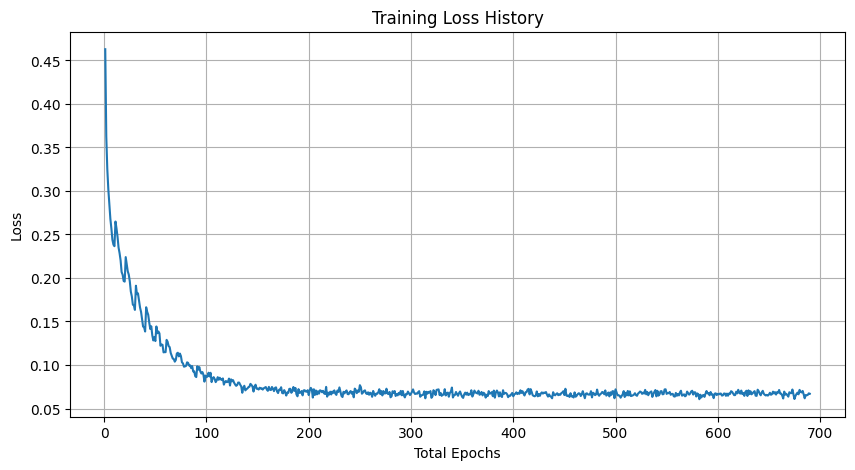

Best result: 0.8880 at iteration 2
Prediction saved to y_pred_20250806_180500.csv


In [30]:
plt_loss_history(loss_history, n, epochs)
print(f"Best result: {best_result:.4f} at iteration {best_n}")
# 전체 10000개 샘플에 대한 예측을 저장 (대회 제출 형식)
np.savetxt(y_pred_filename, y_pred_mapped, fmt="%d")
print(f"Prediction saved to {max_y_pred_filename}")